In [45]:
# %pip install -U scipy

In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
project_dir = "/codespace/braintypicality"
sys.path.append(project_dir)

In [2]:
import re
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.colors import LogNorm

from functools import partial
from tqdm import tqdm
from scipy.stats import spearmanr, permutation_test, mannwhitneyu, PermutationMethod, false_discovery_control, rankdata
ATLAS = "AAL+CSF"
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"

TEN_PERCENT = 0.1
FIVE_PERCENT = 0.05
ONE_PERCENT = 0.01

In [3]:
def statistic(x, y, dof, axis=0):  # explore all possible pairings by permuting `x`
    rs = spearmanr(x, y, axis=axis).statistic  # ignore pvalue
    transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
    return transformed

def run_correlation_analysis(samples,
                             behavior_cols,
                             roi_score_threshold_quantile=0.8,
                             relevant_roi_columns = None,
                             correlation_thresh=0.5,
                             n_resamples=10_000):
    
    # Only keep ROIs above reference threshold on average
    if relevant_roi_columns is None:
        roi_thresh = reference_likelihoods.quantile(roi_score_threshold_quantile)
        relevant_roi_columns = samples[reference_likelihoods.columns].mean() > roi_thresh
        relevant_roi_columns = list(relevant_roi_columns[relevant_roi_columns == True].index)
    
    msma_scores = samples[relevant_roi_columns]
    behavior_scores = samples[behavior_cols]
    corrmatrix, _ = spearmanr(msma_scores, behavior_scores)
    featnames = relevant_roi_columns+behavior_cols
    corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
    
    dof = len(samples) - 2
    corrs = corrmatrix.loc[relevant_roi_columns, behavior_cols].stack()
#     significant_correlation = (corrs.abs() > correlation_thresh).values
#     corrs = corrs[significant_correlation]

    print("Running permutation test ... ")
    print(f"Correlation Threshold: {correlation_thresh}")
    print(f"Feature Pairs: {corrs.shape[0]} ")
    print(f"Maximum DOF: {dof} ")
    
    sigcorrs = []
    for row in tqdm(corrs.items()):
        (roi, bhv), corr = row
        x,y = samples[roi], samples[bhv]
        nonmissing = y > -1
        
        if nonmissing.sum() < 10: continue
        
        x,y = x[nonmissing], y[nonmissing]
        dof = len(x) - 2
        
        ref = permutation_test((x, ), partial(statistic, y=y, dof=dof), vectorized=False,
                               n_resamples=n_resamples, alternative='two-sided', permutation_type='pairings')
        sigcorrs.append((roi, bhv, corr, ref.pvalue, len(y)))
    
    sigcorrdf = pd.DataFrame(sigcorrs, columns=['ROI', "Behavior", "Corr", "p-value", "nsamples"]
                                ).sort_values(by='Corr', ascending=False, key=lambda x: abs(x))#.set_index(['ROI', 'Behavior'])
    
    return corrmatrix, sigcorrdf, relevant_roi_columns

## Loading Voxel-wise Scores

In [4]:
roi_score_likelihoods = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/{ATLAS}_roi_likelihoods.csv")
roi_columns = roi_score_likelihoods.columns.difference(['Cohort', "ID"])
roi_score_likelihoods.describe()

background         CSF  Precentral_L  Precentral_R  Frontal_Sup_L  \
count  319.000000  319.000000    319.000000    319.000000     319.000000   
mean   -52.319597   -0.377818    -16.516151    -16.224555     -13.818043   
std      3.546803    1.228652      1.456727      1.556727       1.815214   
min    -56.578876   -2.319088    -18.865427    -19.293846     -16.664347   
25%    -54.264077   -1.154375    -17.479531    -17.163305     -14.953725   
50%    -53.372475   -0.594116    -16.710178    -16.546534     -14.171143   
75%    -51.783491   -0.008909    -15.920045    -15.728770     -13.174180   
max    -27.150005    7.890209     -5.713173     -5.071681      -2.370178   

       Frontal_Sup_R  Frontal_Sup_Orb_L  Frontal_Sup_Orb_R  Frontal_Mid_L  \
count     319.000000         319.000000         319.000000     319.000000   
mean      -14.786558          -7.952232          -7.362655     -14.798461   
std         1.858061           1.738513           1.847489       1.813877   
min       -17.834581         -11.162533         -10.705958     -17.992964   
25%       -16.054201          -9.079662          -8.609350     -15.953917   
50%       -15.222399          -8.296599          -7.697394     -15.106338   
75%       -14.250692          -7.268675          -6.743108     -14.188337   
max        -3.197154          -0.232863           2.750425      -4.293357   

       Frontal_Mid_R  ...  Cerebelum_10_L  Cerebelum_10_R  Vermis_1_2  \
count     319.000000  ...      319.000000      319.000000  319.000000   
mean      -14.637856  ...       -3.204714       -2.568465    1.004282   
std         1.835720  ...        1.930059        2.248261    3.632817   
min       -17.878504  ...       -8.171700       -6.777907   -7.101626   
25%       -15.746493  ...       -4.510982       -4.010949   -1.564713   
50%       -15.056453  ...       -3.428044       -3.018079    0.242059   
75%       -14.231890  ...       -2.331557       -1.634686    3.056741   
max        -1.176398  ...        4.721942        7.006848   13.638239   

         Vermis_3  Vermis_4_5    Vermis_6    Vermis_7    Vermis_8    Vermis_9  \
count  319.000000  319.000000  319.000000  319.000000  319.000000  319.000000   
mean    -3.963514  -10.803113  -13.258068  -14.839645  -14.311450  -11.692039   
std      2.708830    1.821178    2.177873    2.238607    1.970837    2.600565   
min    -11.365950  -14.709953  -17.588547  -18.750265  -18.642620  -16.613453   
25%     -5.904717  -12.017765  -14.647789  -16.358936  -15.575236  -13.279220   
50%     -4.043064  -10.996241  -13.579793  -15.144185  -14.677023  -12.035291   
75%     -2.266750   -9.938312  -12.436849  -13.679595  -13.352628  -10.477822   
max      8.454497    0.980924    0.889772   -1.840893   -5.027266    1.283823   

        Vermis_10  
count  319.000000  
mean     1.828034  
std      2.952854  
min     -5.228525  
25%     -0.073873  
50%      1.782930  
75%      3.719014  
max     10.714840  

[8 rows x 118 columns]

In [5]:
reference_likelihoods = pd.read_csv(f"{workdir}/eval/heatmaps_v2/roi/training-{ATLAS}_roi_likelihoods.csv")
reference_likelihoods

background       CSF  Precentral_L  Precentral_R  Frontal_Sup_L  \
0    -52.405773 -1.160594    -16.240720    -15.420356     -13.174262   
1    -53.402084  0.589674    -16.218039    -16.240524     -12.814417   
2    -53.377735  0.354789    -16.782894    -15.423598     -13.801647   
3    -53.366486 -1.123906    -14.828829    -16.024061     -11.564390   
4    -54.079800 -0.805278    -15.471673    -15.820291     -12.870411   
..          ...       ...           ...           ...            ...   
325  -56.249020 -2.643489    -16.350897    -16.684572     -14.756400   
326  -52.580654 -0.585214    -14.549687    -15.862584     -13.132694   
327  -51.015700  0.189976    -16.854430    -16.476469     -14.186939   
328  -57.438920 -2.173401    -17.137371    -16.613934     -14.874028   
329  -53.114166 -1.181961    -16.999947    -17.979078     -15.339323   

     Frontal_Sup_R  Frontal_Sup_Orb_L  Frontal_Sup_Orb_R  Frontal_Mid_L  \
0       -14.156552          -7.823804          -4.615128     -14.945374   
1       -14.059655          -6.404532          -6.504943     -14.161819   
2       -13.938385          -6.296635          -6.754046     -14.851440   
3       -11.740133          -6.887378          -7.011018     -13.014995   
4       -12.842586          -9.030422          -6.099383     -14.213899   
..             ...                ...                ...            ...   
325     -15.867616          -9.001400          -8.668185     -15.575353   
326     -13.948072          -9.040503          -7.104403     -13.877936   
327     -14.068050          -7.800881          -5.969154     -15.419061   
328     -15.464175          -9.022839         -10.262229     -17.379310   
329     -15.572917          -8.888371          -9.644242     -16.351866   

     Frontal_Mid_R  ...  Cerebelum_10_L  Cerebelum_10_R  Vermis_1_2  Vermis_3  \
0       -14.115917  ...        0.274043       -1.931260   -2.772257 -1.809489   
1       -14.106808  ...        1.904382        0.368827    0.593147 -7.963304   
2       -14.423994  ...       -2.394596        1.226850    2.177078 -3.667122   
3       -13.505042  ...       -2.102789       -4.208999   -5.066557 -7.836586   
4       -13.620967  ...       -1.462058       -2.483546   -0.818634 -7.150911   
..             ...  ...             ...             ...         ...       ...   
325     -16.849012  ...       -4.610546       -2.590799    0.633469 -2.560068   
326     -14.395870  ...       -5.449009       -3.158637    3.477614 -6.643682   
327     -13.989452  ...       -1.912146       -2.117533    1.705959 -4.996028   
328     -15.883713  ...       -2.271553       -4.780619   -0.245777 -5.563844   
329     -15.753854  ...       -0.570083       -4.253496   -1.804143 -5.885356   

     Vermis_4_5   Vermis_6   Vermis_7   Vermis_8   Vermis_9  Vermis_10  
0    -12.854198  -9.614663 -10.075984  -9.784621 -13.246734  -0.820748  
1     -8.854574 -13.252735 -10.851413  -9.404264  -8.134412   2.729643  
2     -8.187992 -14.593800 -17.832844 -13.660639  -9.626647   7.527297  
3    -11.836378 -15.871938 -17.315775 -16.632887 -13.647439  -0.835417  
4    -14.199053 -14.393287  -9.442236  -8.504608 -10.238399   2.698345  
..          ...        ...        ...        ...        ...        ...  
325  -10.341605 -11.887557 -13.747066 -12.237647 -12.317142   3.320579  
326   -9.087432 -10.681849 -12.933929 -16.553982 -14.615436   0.704811  
327  -10.097131 -12.048326 -11.650540 -12.399459 -10.757129  11.106877  
328  -11.853545 -11.206584 -15.898020 -15.389916  -9.948182   3.416188  
329  -10.508652 -12.445095 -13.799177 -12.989284  -9.682922   4.664731  

[330 rows x 118 columns]

In [6]:
ibis_metadata = pd.read_csv("/ASD/ahsan_projects/braintypicality/dataset/ibis_metadata_v2.csv")
ibis_metadata.index = ibis_metadata["CandID"].apply(lambda x: "IBIS" + str(x))
ibis_metadata.index.name = "ID"
ibis_metadata = ibis_metadata.astype(np.float32, errors="ignore")

das_cols = [c for c in ibis_metadata.columns if "DAS" in c]
cbcl_cols = list(
    filter(
        lambda c: re.match(".*CBCL.*(?<!T)_score", c),
        ibis_metadata.columns,
    )
)
vineland_cols = list(
    filter(lambda c: re.match(".*Vine.*RAW", c), ibis_metadata.columns)
)
ados_cols = list(filter(lambda c: re.match(".*ADOS.*", c), ibis_metadata.columns))

behavior_cols = cbcl_cols + das_cols + vineland_cols + ados_cols

ibis_metadata[behavior_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 423 entries, IBIS389101 to IBIS233336
Data columns (total 49 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   CBCL-aggr_behav_score                                                    423 non-null    float32
 1   CBCL-anx_prob_score                                                      423 non-null    float32
 2   CBCL-anxious_score                                                       423 non-null    float32
 3   CBCL-attention_hyper_prob_score                                          423 non-null    float32
 4   CBCL-attention_prob_score                                                423 non-null    float32
 5   CBCL-conduct_prob_score                                                  423 non-null    float32
 6   CBCL-depressed_score                                           

In [7]:
das_cols

['VSA DAS_SA,PC_ABILITY_SCORE',
 'VSA DAS_SA,matrices_ABILITY_SCORE',
 'VSA DAS_SA,rd_ABILITY_SCORE',
 'VSA DAS_SA,seq_qr_ABILITY_SCORE',
 'VSA DAS_SA,verbal_similarities_ABILITY_SCORE',
 'VSA DAS_SA,word_defn_ABILITY_SCORE']

In [8]:
cbcl_cols

['CBCL-aggr_behav_score',
 'CBCL-anx_prob_score',
 'CBCL-anxious_score',
 'CBCL-attention_hyper_prob_score',
 'CBCL-attention_prob_score',
 'CBCL-conduct_prob_score',
 'CBCL-depressed_score',
 'CBCL-depressive_prob_score',
 'CBCL-externalizing_score',
 'CBCL-internalizing_score',
 'CBCL-obsessive_comp_prob_score',
 'CBCL-oppo_def_prob_score',
 'CBCL-rule_break_behav_score',
 'CBCL-sluggish_cogn_tempo_score',
 'CBCL-social_prob_score',
 'CBCL-som_comp_score',
 'CBCL-som_prob_score',
 'CBCL-stress_prob_score',
 'CBCL-thought_prob_score',
 'CBCL-total_problems_score']

In [9]:
vineland_cols

['Vineland-community_RAW_SCORE',
 'Vineland-copy_skills_RAW_SCORE',
 'Vineland-domestic_RAW_SCORE',
 'Vineland-expressive_RAW_SCORE',
 'Vineland-fine_motor_RAW_SCORE',
 'Vineland-gross_motor_RAW_SCORE',
 'Vineland-inter_pers_rel_RAW_SCORE',
 'Vineland-personal_RAW_SCORE',
 'Vineland-play_leisure_RAW_SCORE',
 'Vineland-receptive_RAW_SCORE',
 'Vineland-written_RAW_SCORE']

In [10]:
roi_score_likelihoods.Cohort.value_counts()

IBIS-HR-Typical    106
IBIS-LR-Typical     82
IBIS-ASD            65
IBIS-Atypical       38
IBIS-DS             28
Name: Cohort, dtype: int64

In [11]:
datadf = pd.merge(roi_score_likelihoods, ibis_metadata, on="ID").drop_duplicates(subset='ID')
datadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 315
Columns: 247 entries, background to Sex
dtypes: float32(75), float64(118), object(54)
memory usage: 513.1+ KB


In [12]:
#datadf.to_csv("roi-msma.csv")

In [13]:
datadf.query("Cohort == 'IBIS-DS'")['Sex']

0     Female
1       Male
3       Male
4       Male
5     Female
6     Female
7       Male
8     Female
9       Male
10      Male
12    Female
13    Female
14    Female
15      Male
16    Female
17    Female
19    Female
20    Female
21      Male
22    Female
23    Female
24      Male
26    Female
27      Male
28      Male
29      Male
30      Male
31      Male
Name: Sex, dtype: object

#### Not exactly Normal distributed => we should probably use a rank-order test

<Axes: ylabel='Frequency'>

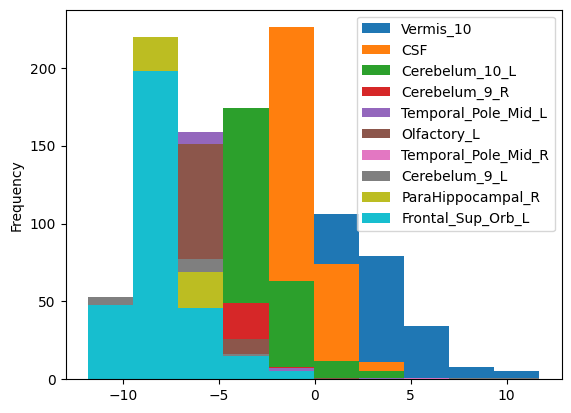

In [14]:
sorted_roi_columns = list(roi_score_likelihoods.mean(numeric_only=True).sort_values(ascending=False).index)
datadf[sorted_roi_columns[0:20:2]].plot(kind='hist')

In [15]:
# df[cbcl_cols].plot(kind='hist')

In [16]:
corrmatrix = datadf.corr(method='spearman', numeric_only=True)
corrmatrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193 entries, background to CBCL-total_problems_score
Columns: 193 entries, background to CBCL-total_problems_score
dtypes: float64(193)
memory usage: 296.6+ KB


CPU times: user 176 ms, sys: 189 ms, total: 365 ms
Wall time: 163 ms


<Axes: >

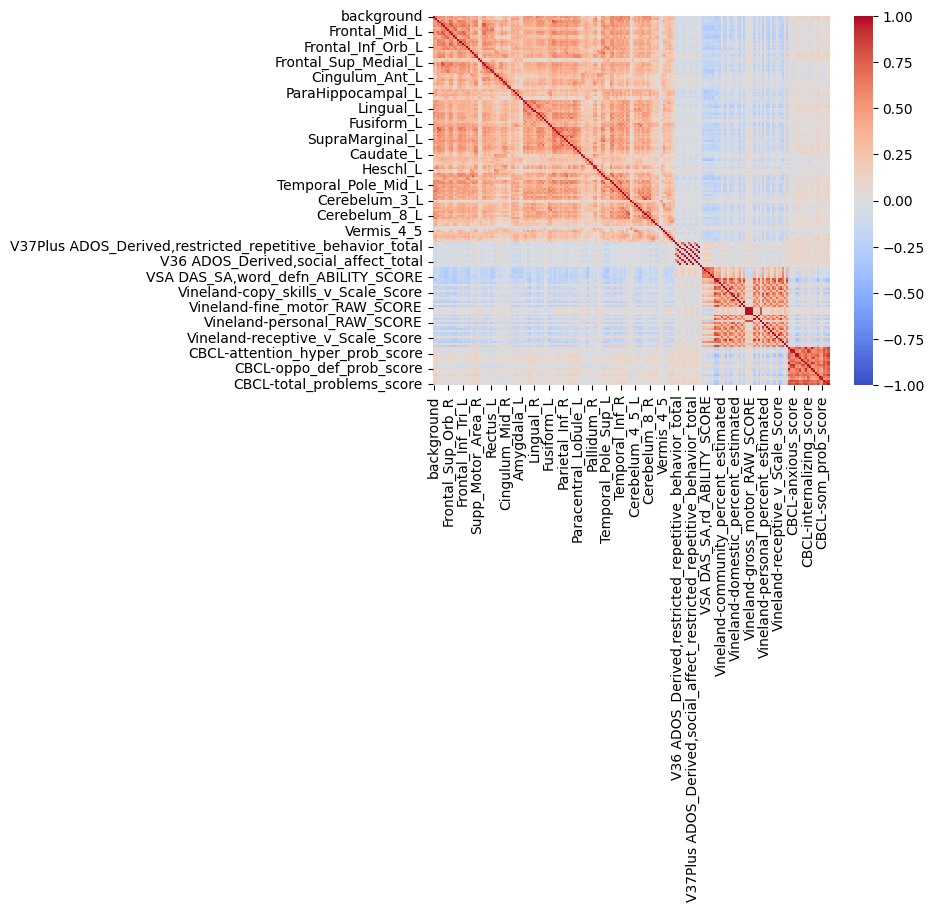

In [17]:
%%time
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1)

In [18]:
msma_scores = datadf[sorted_roi_columns]
behavior_scores = datadf[behavior_cols]
corrmatrix, pvalues = spearmanr(msma_scores, behavior_scores)
featnames = list(msma_scores.columns) + list(behavior_scores.columns)
corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
pvalues = pd.DataFrame(pvalues, columns=featnames, index=featnames)

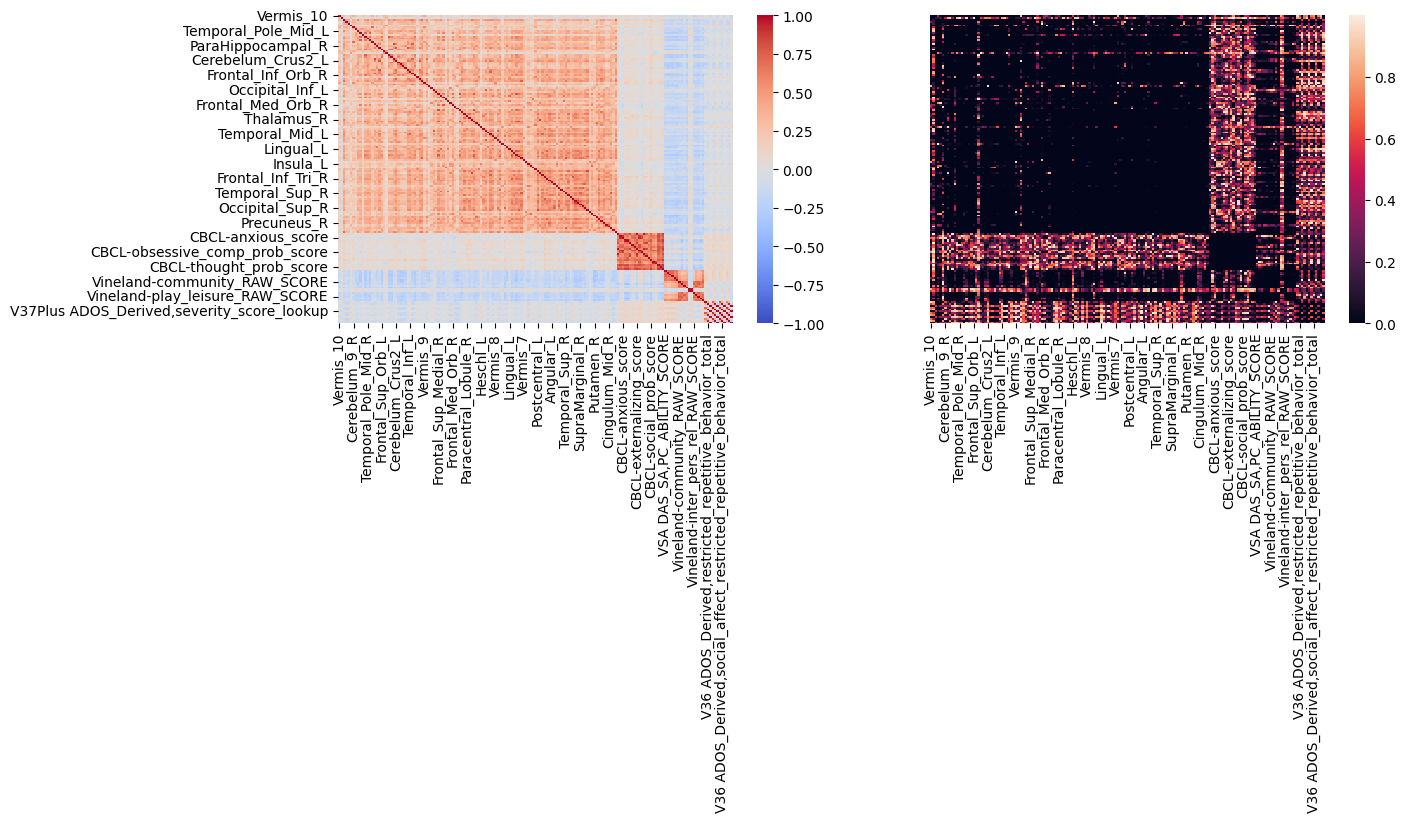

In [19]:
fig, axs = plt.subplots(1,2, figsize=(14,4))
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
sns.heatmap(pvalues, ax=axs[1])
axs[1].yaxis.set_visible(False)

<Axes: >

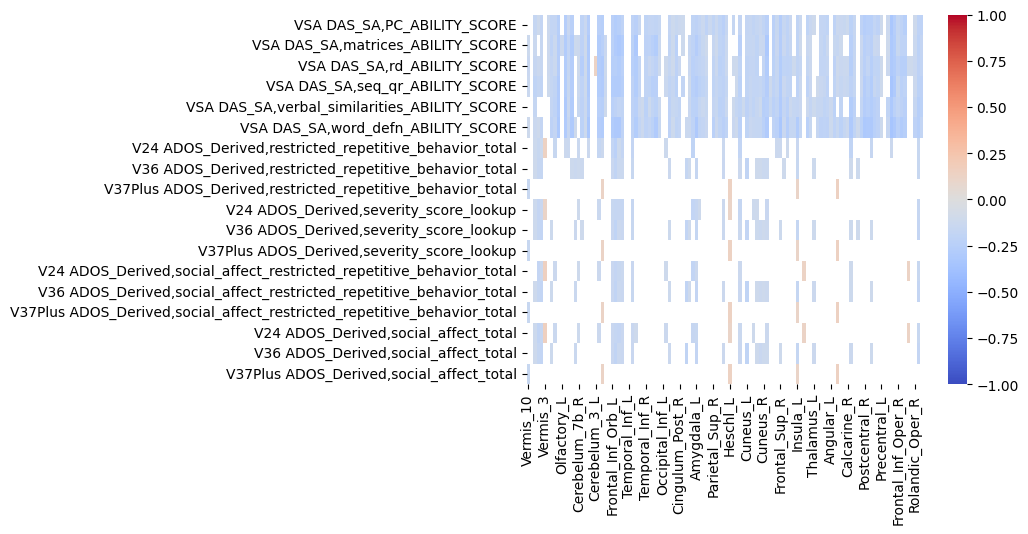

In [20]:
significant = pvalues < 0.05
sns.heatmap(corrmatrix[significant].loc[das_cols+ados_cols, sorted_roi_columns, ],  cmap='coolwarm', vmin=-1, vmax=1, )

## Separating into Atypical Cohorts

In [21]:
roi_score_likelihoods.Cohort.value_counts()

IBIS-HR-Typical    106
IBIS-LR-Typical     82
IBIS-ASD            65
IBIS-Atypical       38
IBIS-DS             28
Name: Cohort, dtype: int64

<Axes: ylabel='Frequency'>

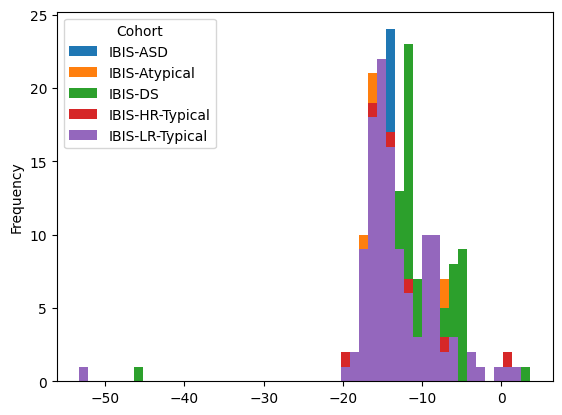

In [22]:
roi_score_likelihoods.drop(columns='ID').pivot_table(columns='Cohort').plot.hist(bins=50)

In [23]:
plotdf = roi_score_likelihoods.query("Cohort == 'IBIS-DS' | Cohort == 'IBIS-LR-Typical'")[list(roi_columns) + ['Cohort']].pivot_table(columns='Cohort')
plotdf = plotdf.melt()
plotdf.head()

Cohort      value
0  IBIS-DS -11.306047
1  IBIS-DS -10.672110
2  IBIS-DS -13.674785
3  IBIS-DS -14.140289
4  IBIS-DS   2.046153

<Axes: xlabel='value', ylabel='Density'>

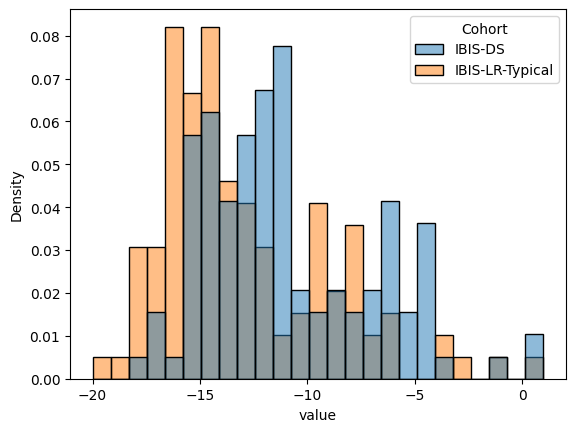

In [24]:
sns.histplot(plotdf, x='value', hue='Cohort', kde=False, stat='density', binrange=(-20,1), bins=25)

In [25]:
atypicals = datadf[datadf['Cohort'].isin(['IBIS-DS'])]
msma_scores = atypicals[sorted_roi_columns]
behavior_scores = atypicals[behavior_cols]

corrmatrix, pvalues = spearmanr(msma_scores, behavior_scores)
featnames = sorted_roi_columns+behavior_cols
corrmatrix = pd.DataFrame(corrmatrix, columns=featnames, index=featnames)
pvalues = pd.DataFrame(pvalues, columns=featnames, index=featnames)

/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [26]:
# behavior_scores[cbcl_cols].plot(kind='hist', subplots=True, layout=(5,4), figsize=(12,12))

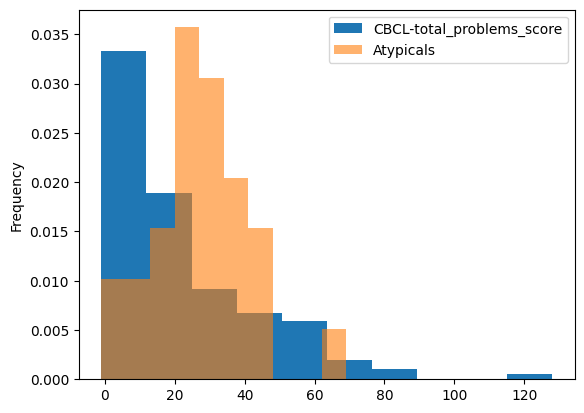

In [27]:
datadf['CBCL-total_problems_score'].plot(kind='hist', density=True)
behavior_scores['CBCL-total_problems_score'].plot(kind='hist', density=True,label="Atypicals", alpha=0.6)
plt.legend()

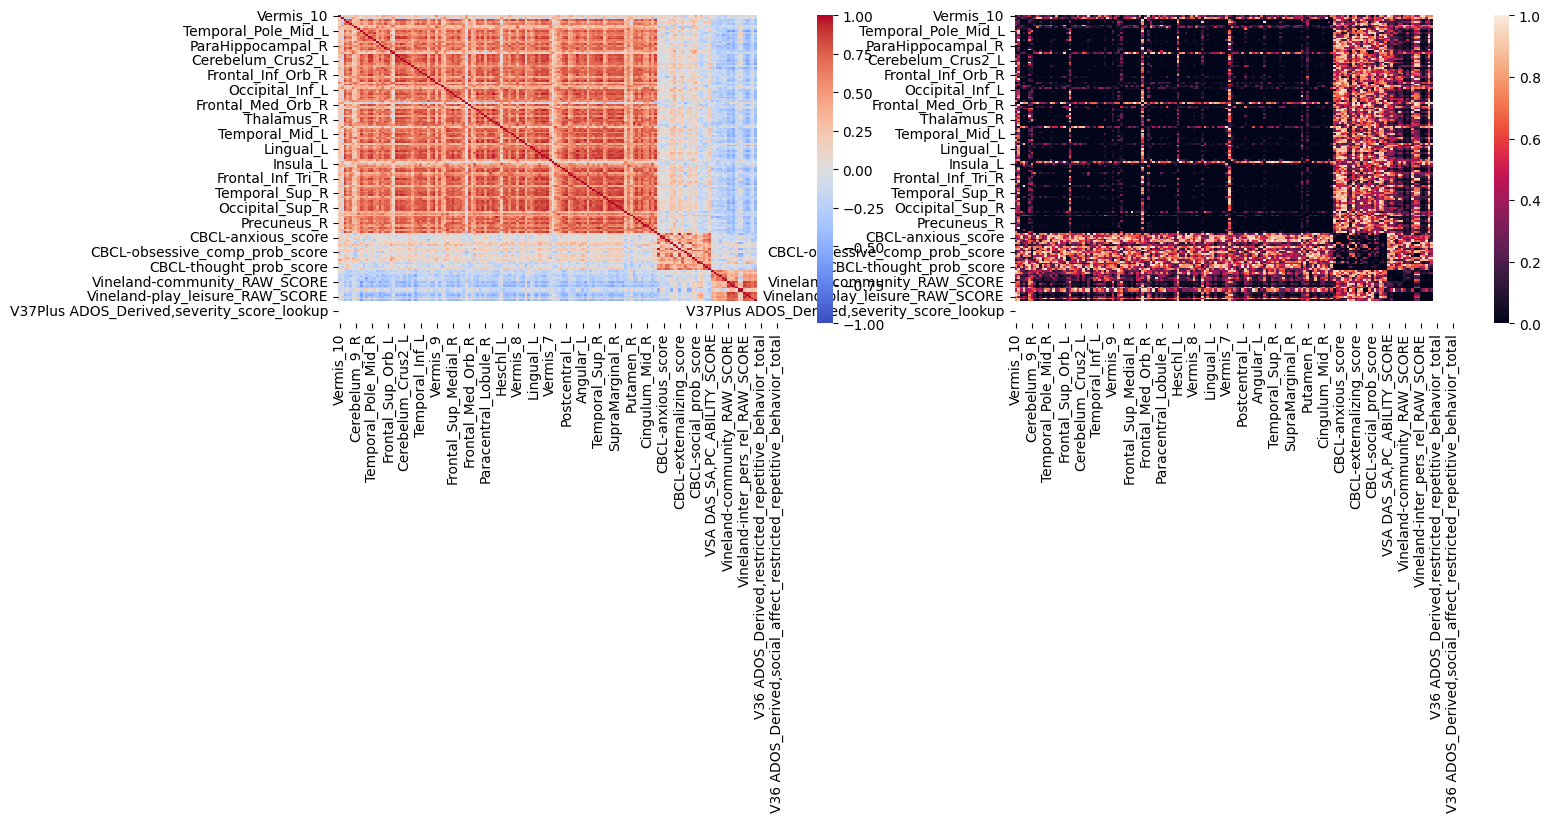

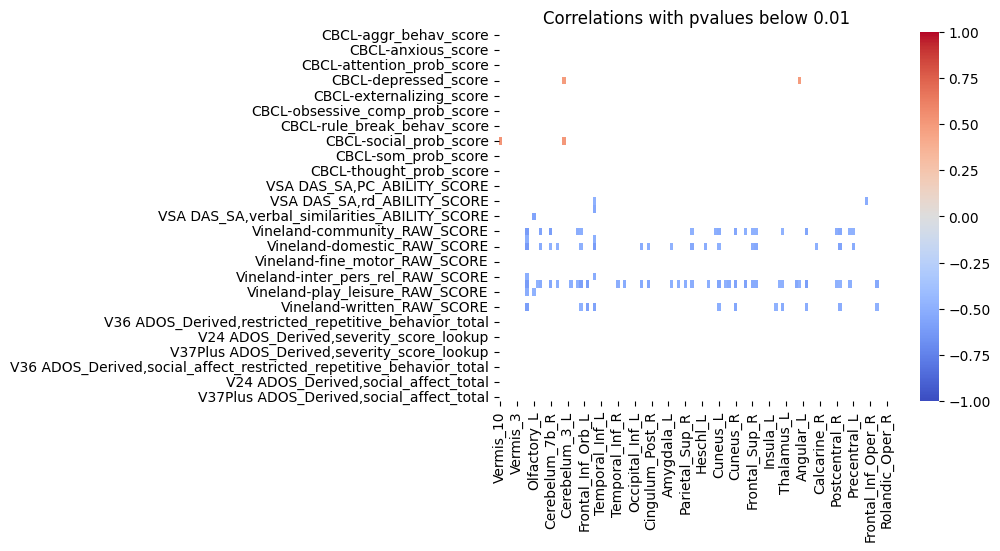

In [28]:
fig, axs = plt.subplots(1,2, figsize=(16,4))
sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
sns.heatmap(pvalues, ax=axs[1])
plt.show()

pval = 0.01
significant = pvalues < pval
sns.heatmap(corrmatrix[significant].loc[behavior_cols, sorted_roi_columns],  cmap='coolwarm',
            vmin=-1, vmax=1, )
plt.title(f"Correlations with pvalues below {pval}");

### Correlations between different behavior scores

In [29]:
cval = 0.4
significant_correlation = corrmatrix.abs() > cval

Text(0.5, 1.0, 'Absolute correlations above 0.4')

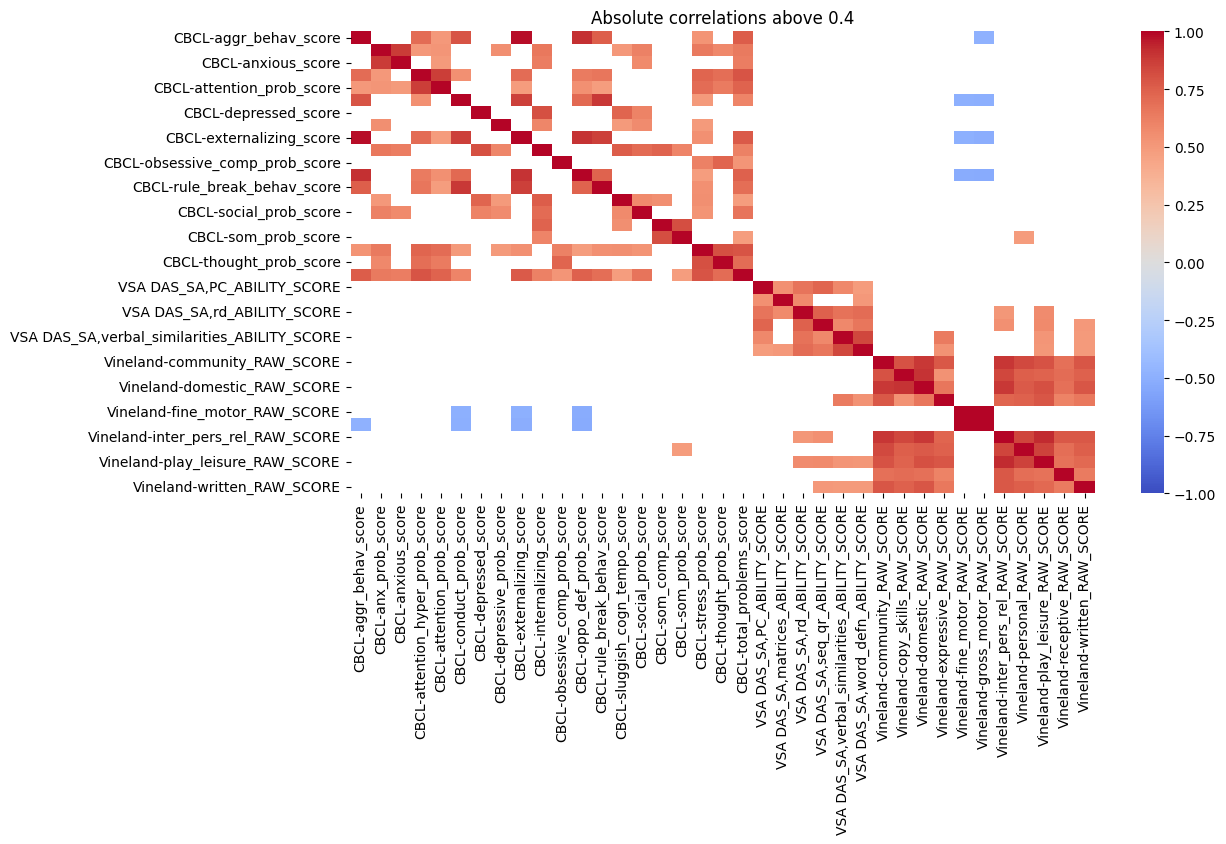

In [30]:
corrs = corrmatrix[significant].loc[behavior_cols, behavior_cols]
keepcols = corrs.count()[corrs.count() > 2].index
plt.figure(figsize=(12,6))
sns.heatmap(corrs.loc[keepcols, keepcols],cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Absolute correlations above {cval}")

Text(0.5, 1.0, 'Absolute correlations above 0.4')

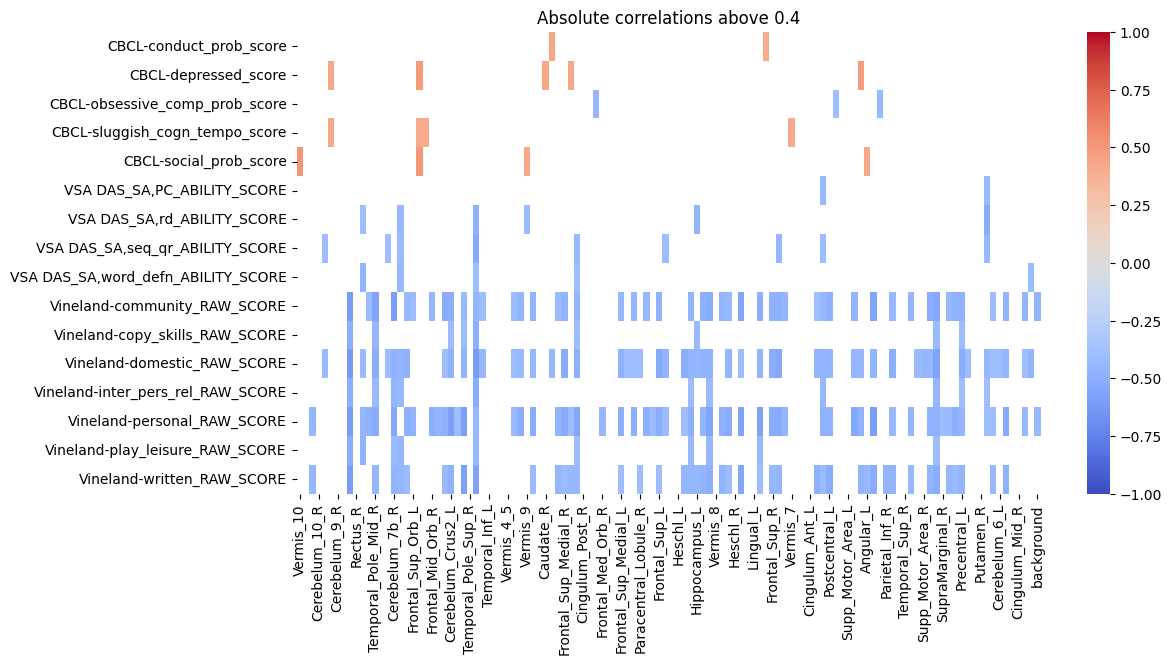

In [31]:
corrs = corrmatrix[significant_correlation].loc[sorted_roi_columns, behavior_cols]
keepcols = corrs.count()[corrs.count() > 1].index
plt.figure(figsize=(12,6))
sns.heatmap(corrmatrix[significant_correlation].loc[keepcols, sorted_roi_columns],
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Absolute correlations above {cval}")

### Which Assessment shows high correlation with MSMA scores?

In [32]:
corrmatrix[significant_correlation].loc[sorted_roi_columns, behavior_cols].count(axis='rows').sort_values(ascending=False)[:10]

Vineland-personal_RAW_SCORE          58
Vineland-domestic_RAW_SCORE          54
Vineland-community_RAW_SCORE         48
Vineland-written_RAW_SCORE           45
Vineland-inter_pers_rel_RAW_SCORE    11
Vineland-play_leisure_RAW_SCORE      10
Vineland-copy_skills_RAW_SCORE        9
VSA DAS_SA,seq_qr_ABILITY_SCORE       9
VSA DAS_SA,rd_ABILITY_SCORE           6
CBCL-depressed_score                  5
dtype: int64

### Which Brain ROIs shows high correlation with assessments?

<Axes: >

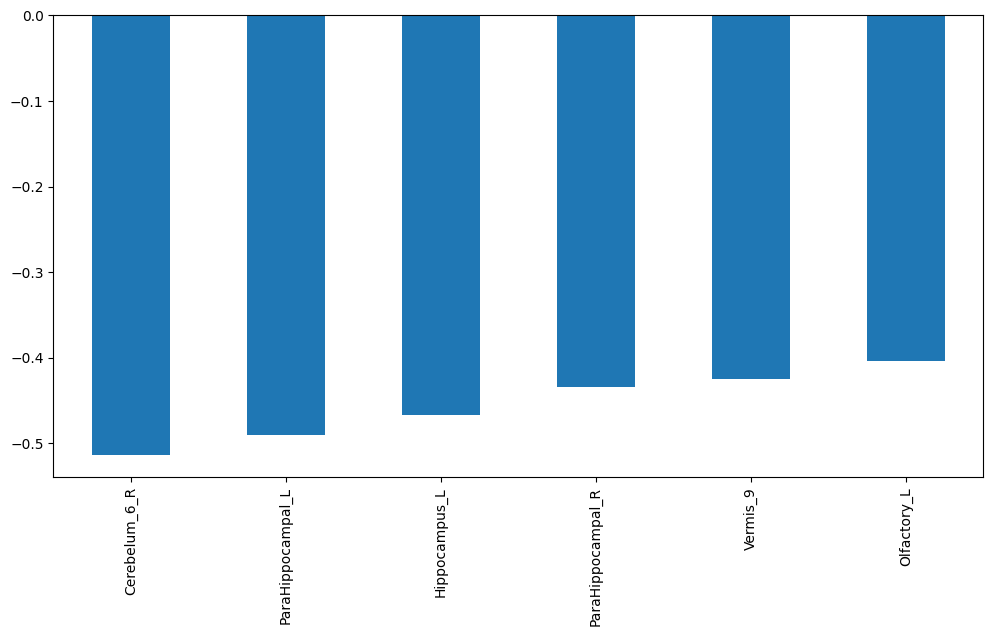

In [33]:
corrmatrix[significant_correlation].loc[sorted_roi_columns, 'VSA DAS_SA,rd_ABILITY_SCORE'].dropna().sort_values().plot(kind='bar', figsize=(12,6))

In [34]:
spearmanr(msma_scores['Cerebelum_6_R'], behavior_scores['VSA DAS_SA,rd_ABILITY_SCORE'])

SignificanceResult(statistic=-0.5139494745662078, pvalue=0.0051477238446801035)

In [35]:
%%time
x,y = msma_scores['Cerebelum_8_R'], behavior_scores['VSA DAS_SA,seq_qr_ABILITY_SCORE']
ref = permutation_test((x, ), partial(statistic, y=y, dof=len(msma_scores)), vectorized=False,
                       alternative='two-sided', permutation_type='pairings')

ref

CPU times: user 7.81 s, sys: 14.6 ms, total: 7.82 s
Wall time: 7.85 s


PermutationTestResult(statistic=-0.7520698905038166, pvalue=0.4856, null_distribution=array([ 1.2829412 ,  0.38940339,  0.87911172, ..., -0.08468937,
        0.25432883,  1.88107003]))

In [36]:
plotdf = datadf.copy()
plotdf[sorted_roi_columns+behavior_cols] = plotdf[sorted_roi_columns+behavior_cols].apply(rankdata)

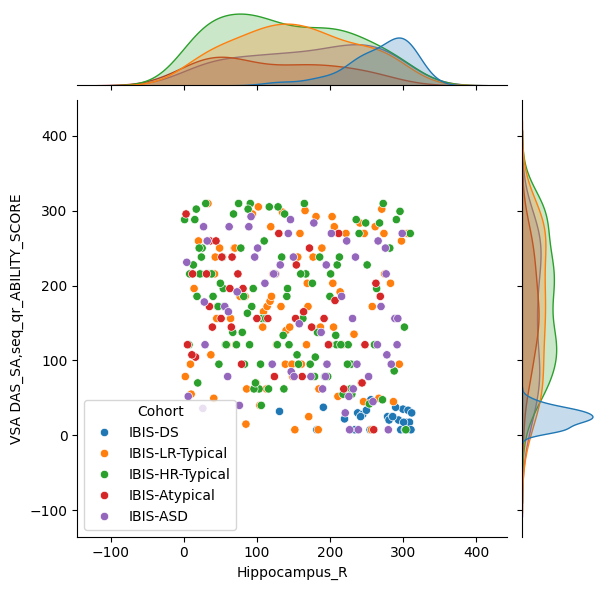

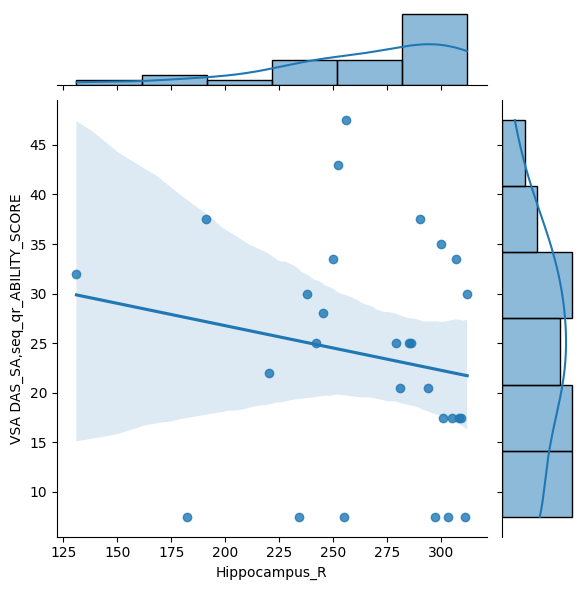

In [37]:
sns.jointplot(x='Hippocampus_R', y='VSA DAS_SA,seq_qr_ABILITY_SCORE', data=plotdf, hue='Cohort',)
plt.show()
sns.jointplot(x='Hippocampus_R', y='VSA DAS_SA,seq_qr_ABILITY_SCORE', data=plotdf.query("Cohort == 'IBIS-DS'"), kind='reg',)

In [38]:
plotdf.query("Cohort == 'IBIS-DS'").Sex.value_counts()

Female    14
Male      14
Name: Sex, dtype: int64

# Analyzing DS-Prototype Samples 

In [39]:
dssamples = datadf.query("Cohort == 'IBIS-DS'")
ds_bmu_ids = pd.read_csv("ds_prototypes_13x13.csv")
largest_prototype_bmu_idx = ds_bmu_ids.groupby('bmu').count().idxmax()[0]
ds_max_prototype_ids = ds_bmu_ids[ds_bmu_ids.bmu == largest_prototype_bmu_idx]['ID']
prot_ids_set = set(ds_max_prototype_ids)
ds_prototypes = dssamples.merge(ds_max_prototype_ids, on='ID')
ds_non_prototypes = dssamples[~dssamples['ID'].isin(ds_max_prototype_ids)]
len(ds_prototypes), len(ds_non_prototypes)

(16, 12)

In [40]:
ds_metadata = pd.read_csv("/ASD/ahsan_projects/braintypicality/dataset/ds_metadata.csv").replace(np.nan, 0)
ds_metadata['ID'] = "IBIS" + ds_metadata['CandID'].astype(str)
ds_proto_metadata = pd.merge(ds_prototypes, ds_metadata, on='ID')
ds_proto_metadata['Met ASD CutOff'] = ds_proto_metadata['MetASDCutOff'].map({0: False, 1: True})
ds_proto_metadata['Met ASD CutOff']

0     False
1      True
2     False
3     False
4     False
5     False
6     False
7     False
8      True
9      True
10     True
11    False
12     True
13     True
14    False
15    False
Name: Met ASD CutOff, dtype: bool

<Axes: >

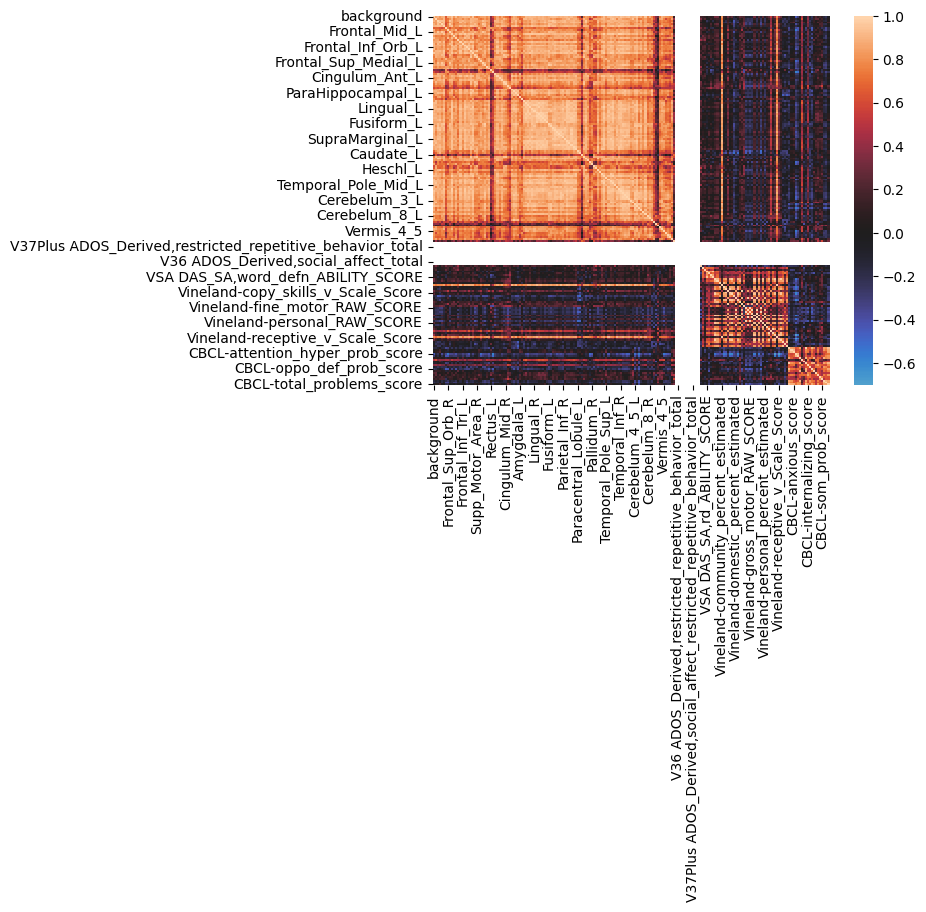

In [41]:
sns.heatmap(ds_prototypes.corr(numeric_only=True), center=0)

In [42]:
relevant_rois = datadf.query("Cohort == 'IBIS-DS'")[roi_columns].mean() > datadf.query("Cohort == 'IBIS-LR-Typical'")[roi_columns].quantile(0.9)
relevant_rois = relevant_rois.index[relevant_rois]
relevant_rois = relevant_rois.drop(['background'])
len(relevant_rois)

71

In [43]:
%%time
np.random.seed(42)
statistics = []

for c in tqdm(relevant_rois):
    statistics.append(
        mannwhitneyu(ds_prototypes[c], ds_non_prototypes[c],
                     method=PermutationMethod(n_resamples=10_000))
    )

100%|██████████| 71/71 [00:03<00:00, 21.88it/s]

CPU times: user 2.79 s, sys: 462 ms, total: 3.25 s
Wall time: 3.25 s


In [44]:
pvals = np.asarray([s.pvalue for s in statistics])
adjusted_ps = false_discovery_control(pvals, method='bh')
alpha = 0.01
print(f"FDR: {alpha} -> Significant ROIs: {(adjusted_ps < alpha).sum()} / {len(relevant_rois)}")
alpha = FIVE_PERCENT
print(f"FDR: {alpha} -> Significant ROIs: {(adjusted_ps < alpha).sum()} / {len(relevant_rois)}")

FDR: 0.01 -> Significant ROIs: 55 / 71
FDR: 0.05 -> Significant ROIs: 60 / 71


## Using Bonferoni Correction

In [45]:
ntests = len(pvals)
alphacBonf = alpha / float(ntests)
pvals_corrected = pvals * float(ntests)

In [46]:
significant_prototype_rois = [roi for roi, pval in zip(relevant_rois, pvals) if pval < alphacBonf]
len(significant_prototype_rois)

40

In [47]:
dssamples['Sex'].value_counts()

Female    14
Male      14
Name: Sex, dtype: int64

In [47]:
dssamples.loc[:, 'Subpopulation'] = dssamples['ID'].isin(prot_ids_set)
dssamples.loc[:, 'Subpopulation'] = dssamples['Subpopulation'].map({True:"Maximal-Prototype", False: "Non-Prototype"})
dssamples['Subpopulation'].value_counts()

/tmp/ipykernel_22175/4167399050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dssamples.loc[:, 'Subpopulation'] = dssamples['ID'].isin(prot_ids_set)
/tmp/ipykernel_22175/4167399050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dssamples.loc[:, 'Subpopulation'] = dssamples['Subpopulation'].map({True:"Maximal-Prototype", False: "Non-Prototype"})


Maximal-Prototype    16
Non-Prototype        12
Name: Subpopulation, dtype: int64

In [48]:
# n_sleect = 
prototype_rois = pd.DataFrame(np.stack([relevant_rois, pvals, pvals_corrected], axis=1),
                                          columns=['ROI', 'p-value', 'adjusted']).sort_values(by='adjusted')
significant_prototype_rois = prototype_rois[prototype_rois['p-value'] < alphacBonf]
roi_order = significant_prototype_rois.sort_values(by='p-value', ascending=True)['ROI'].values
plotdf = dssamples.melt(id_vars=['Sex', 'Subpopulation'], var_name='ROI', value_name='Anomaly Score')
plotdf = plotdf[plotdf['ROI'].isin(significant_prototype_rois['ROI'])]
# plotdf = plotdf.sort_values(by='Anomaly')
plotdf

Sex      Subpopulation             ROI Anomaly Score
28    Female  Maximal-Prototype             CSF      3.548188
29      Male  Maximal-Prototype             CSF      1.753893
30      Male      Non-Prototype             CSF       0.81173
31      Male  Maximal-Prototype             CSF      1.692265
32    Female  Maximal-Prototype             CSF       1.18913
...      ...                ...             ...           ...
3075    Male      Non-Prototype  Cerebelum_10_R      1.186513
3076    Male      Non-Prototype  Cerebelum_10_R      0.705907
3077    Male      Non-Prototype  Cerebelum_10_R     -0.830218
3078    Male      Non-Prototype  Cerebelum_10_R      3.413286
3079    Male  Maximal-Prototype  Cerebelum_10_R      1.814161

[1120 rows x 4 columns]

In [49]:
# sns.jointplot(x='Hippocampus_R', y='Cerebelum_10_R', data=plotdf, hue="Subpopulation")

<Axes: >

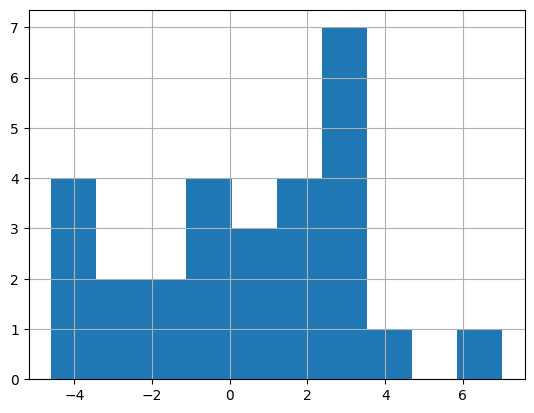

In [50]:
plotdf.query("ROI == 'Cerebelum_10_R'")['Anomaly Score'].hist()

<Axes: xlabel='Anomaly Score', ylabel='Count'>

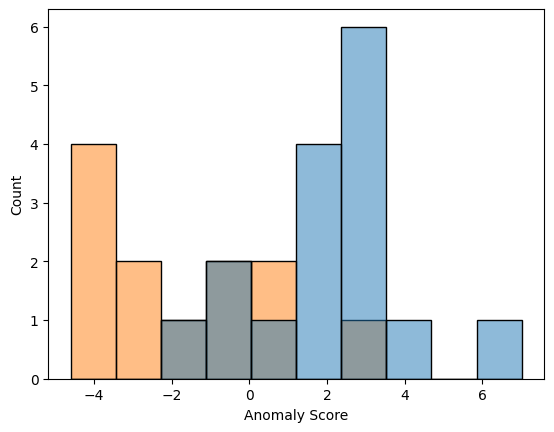

In [51]:
sns.histplot(data=plotdf.query("ROI == 'Cerebelum_10_R'"), x='Anomaly Score', hue='Subpopulation', bins=10, legend=False)

In [52]:
# Set the axis title font size using rcParams
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['figure.titlesize'] = 20
# plt.rcParams['axes.titlesize'] = 16
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 20, "axes.titlesize":22})

/tmp/ipykernel_22175/2726732024.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_22175/2726732024.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_22175/2726732024.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
/tmp/ipykernel_22175/2726732024.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35)


Text(0.5, 1.02, 'Higher is Anomalous ($\\uparrow$)')

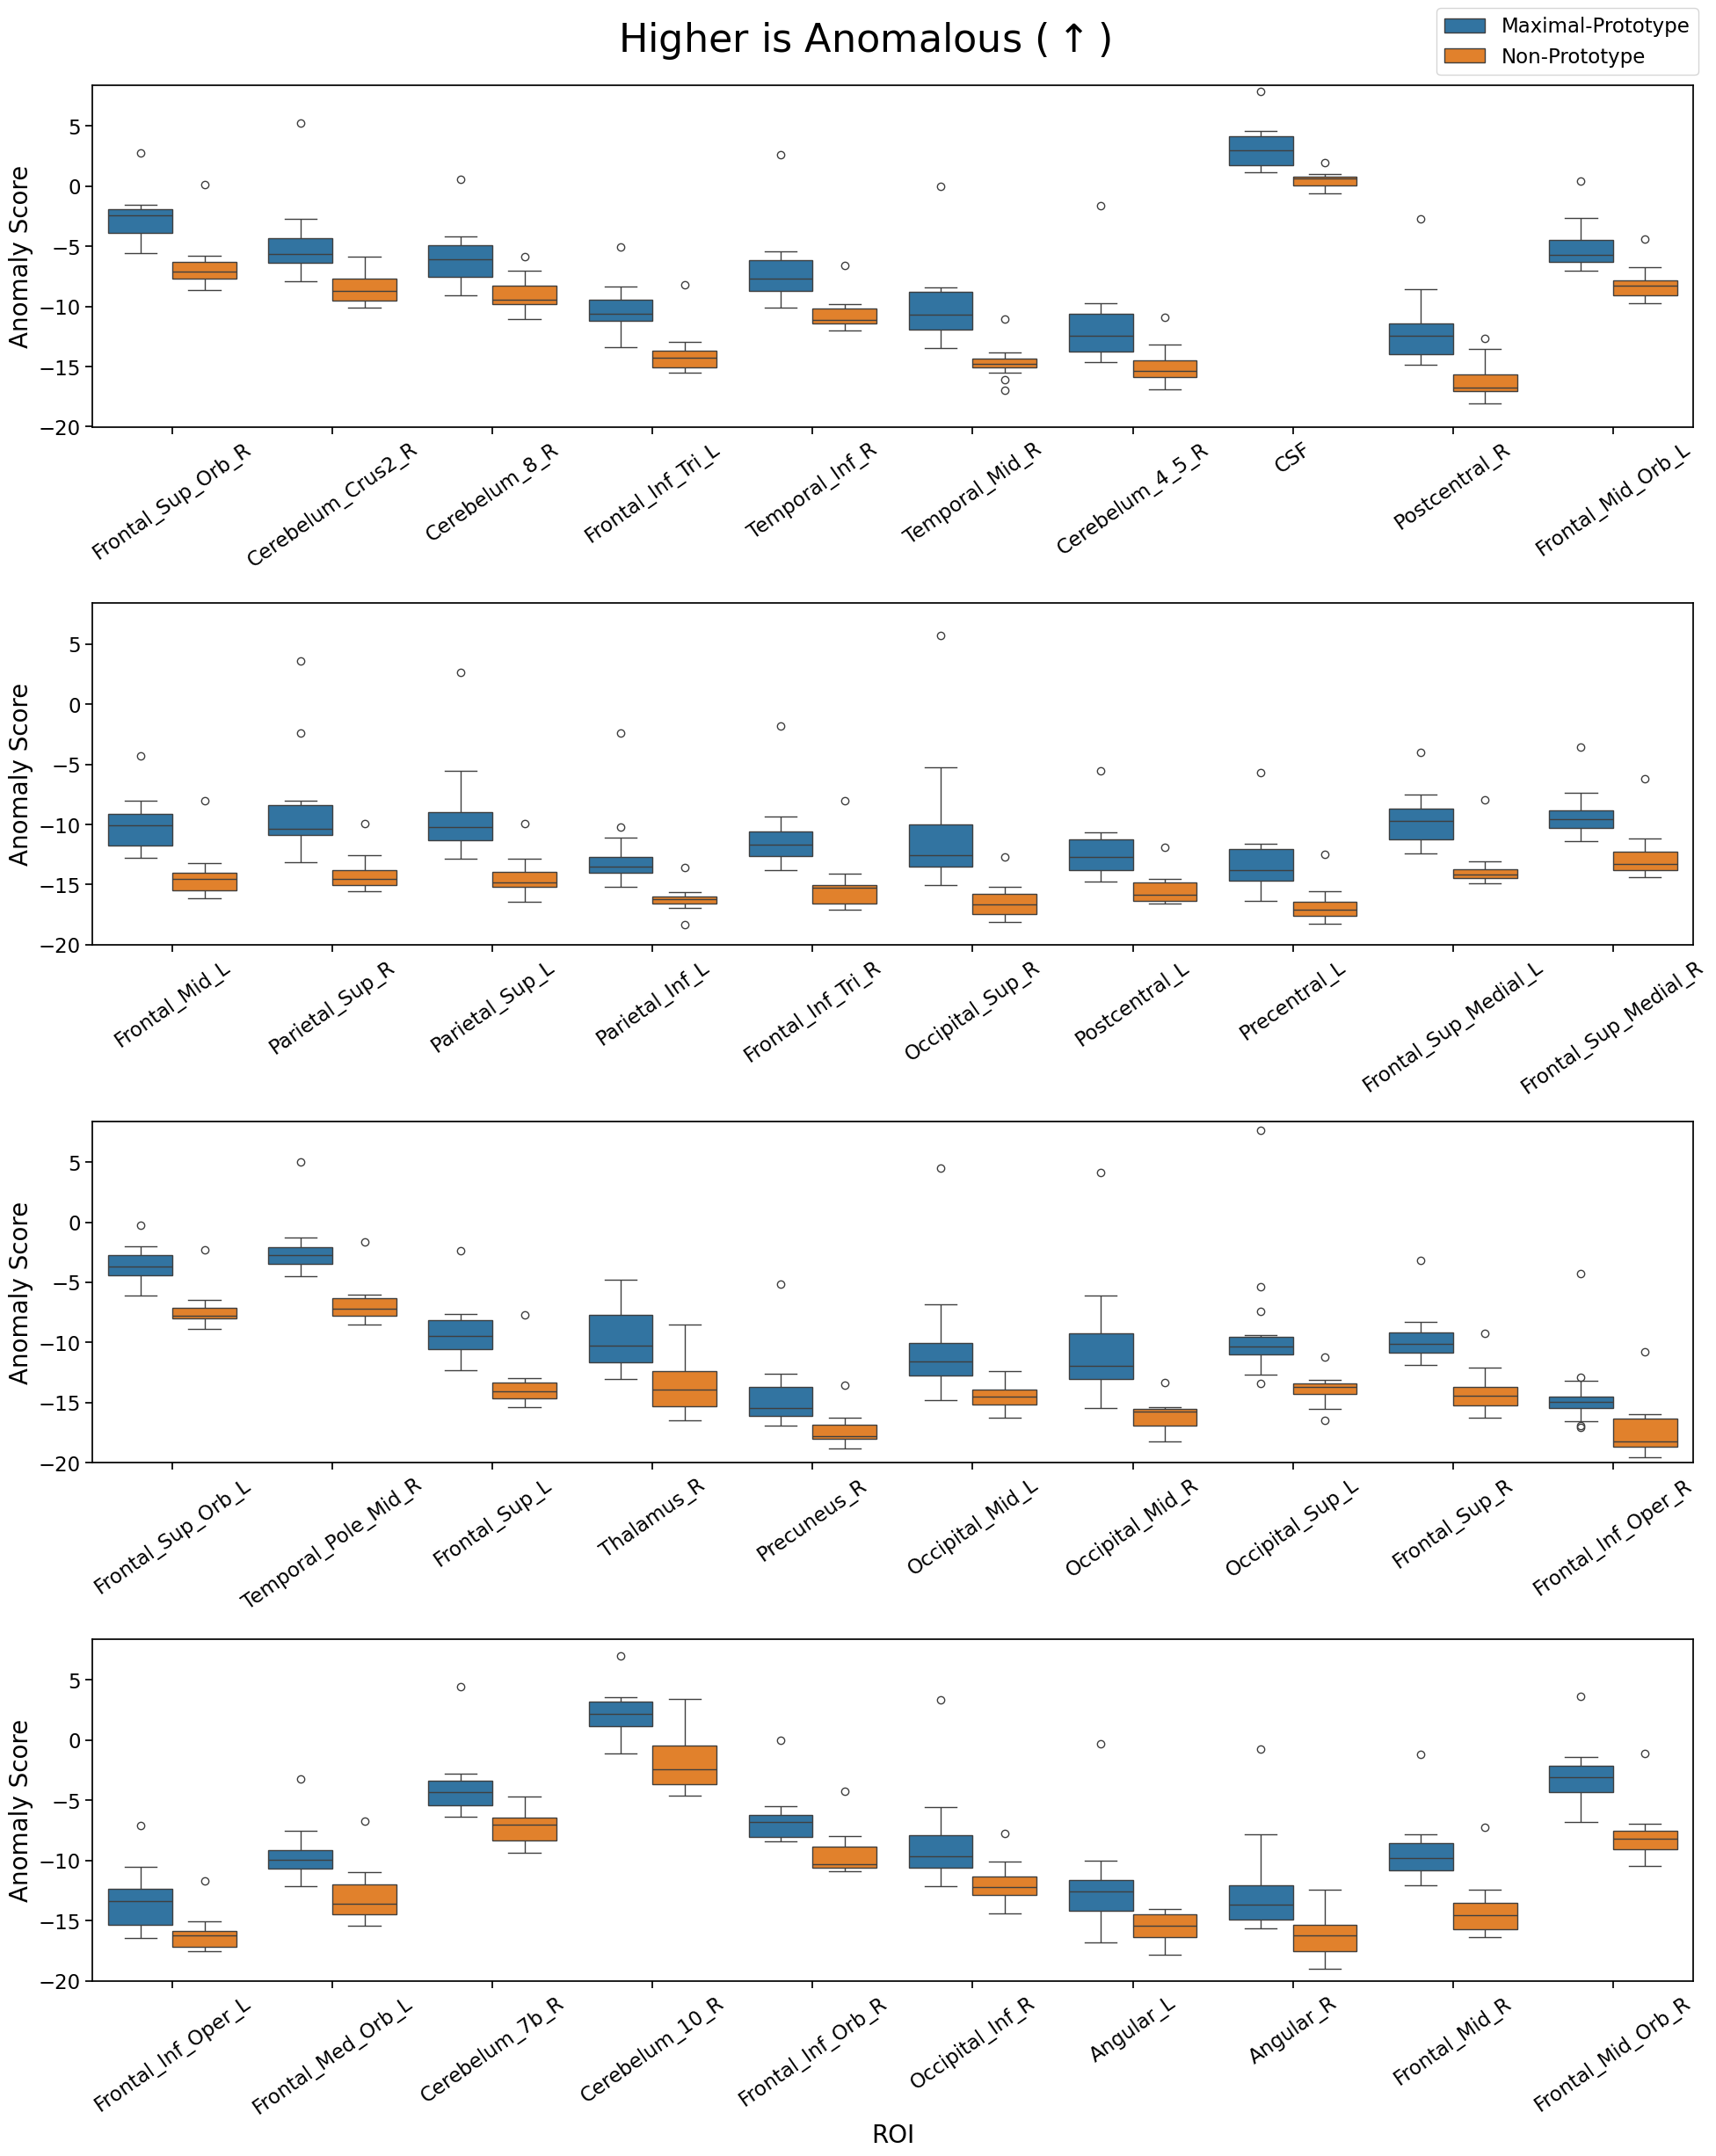

In [53]:
fig, axs = plt.subplots(4,1, figsize=(20, 24))
vmin, vmax = plotdf['Anomaly Score'].min()-0.5, plotdf['Anomaly Score'].max()+0.5
n_per_row = 10
rois_per_row = [roi_order[i:i+n_per_row] for i in range(0, len(roi_order), n_per_row) ]

for i, (ax, _rois) in enumerate(zip(axs, rois_per_row)):
    sns.boxplot(plotdf, x="ROI", y='Anomaly Score', hue='Subpopulation', order=_rois,
                orient='v', palette='tab10', ax=ax, legend=i==0)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
    ax.set_ylim(vmin, vmax)
    if i+1 < len(axs):
        ax.set_xlabel('')
        
    if i==0:
#         ax.legend_.remove()
        
#     if show_legend:
#         show_legend = False
        fig.legend(loc='upper right', bbox_to_anchor=(0.98, 1.03)) #fontsize='large')
        l = ax.legend()
        l.set_visible(False)

# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels,  loc='upper right', bbox_to_anchor=(0.98, 1.03),)
# plt.suptitle("ROIs that are Signficantly Different")
plt.tight_layout()
fig.suptitle(r"Higher is Anomalous ($\uparrow$)", y=1.02, fontsize=32)
# plt.tight_layout(w_pad=2, h_pad=2)
# plt.subplots_adjust(top=0.11)

# plt.savefig('figures/roi_full_boxplot.pdf', dpi=150, bbox_inches='tight')

In [54]:
def add_refline(data, q=0.9, **kws):
    roi = data.iloc[0]['ROI']
    protomedian = plotdf.query(f"Subpopulation == 'Maximal-Prototype' & ROI == '{roi}'")['Anomaly Score'].median()
    p = significant_prototype_rois.query(f"ROI == '{roi}'")['adjusted'].item()
    ax = plt.gca()
#     refline = reference_likelihoods[roi].quantile(0.99)
    refline = roi_score_likelihoods.query("Cohort == 'IBIS-LR-Typical' ")[roi].quantile(q)
    ax.axvline(refline, c='red', linestyle='dashed', label=f'Inlier {int(q*100):d} %-tile')
    ax.axvline(protomedian, c='black', linestyle='-', label='Prototype 50 %-tile')
    ax.set_title(ax.get_title() + f' | p = {p:.3f}', fontsize=14)

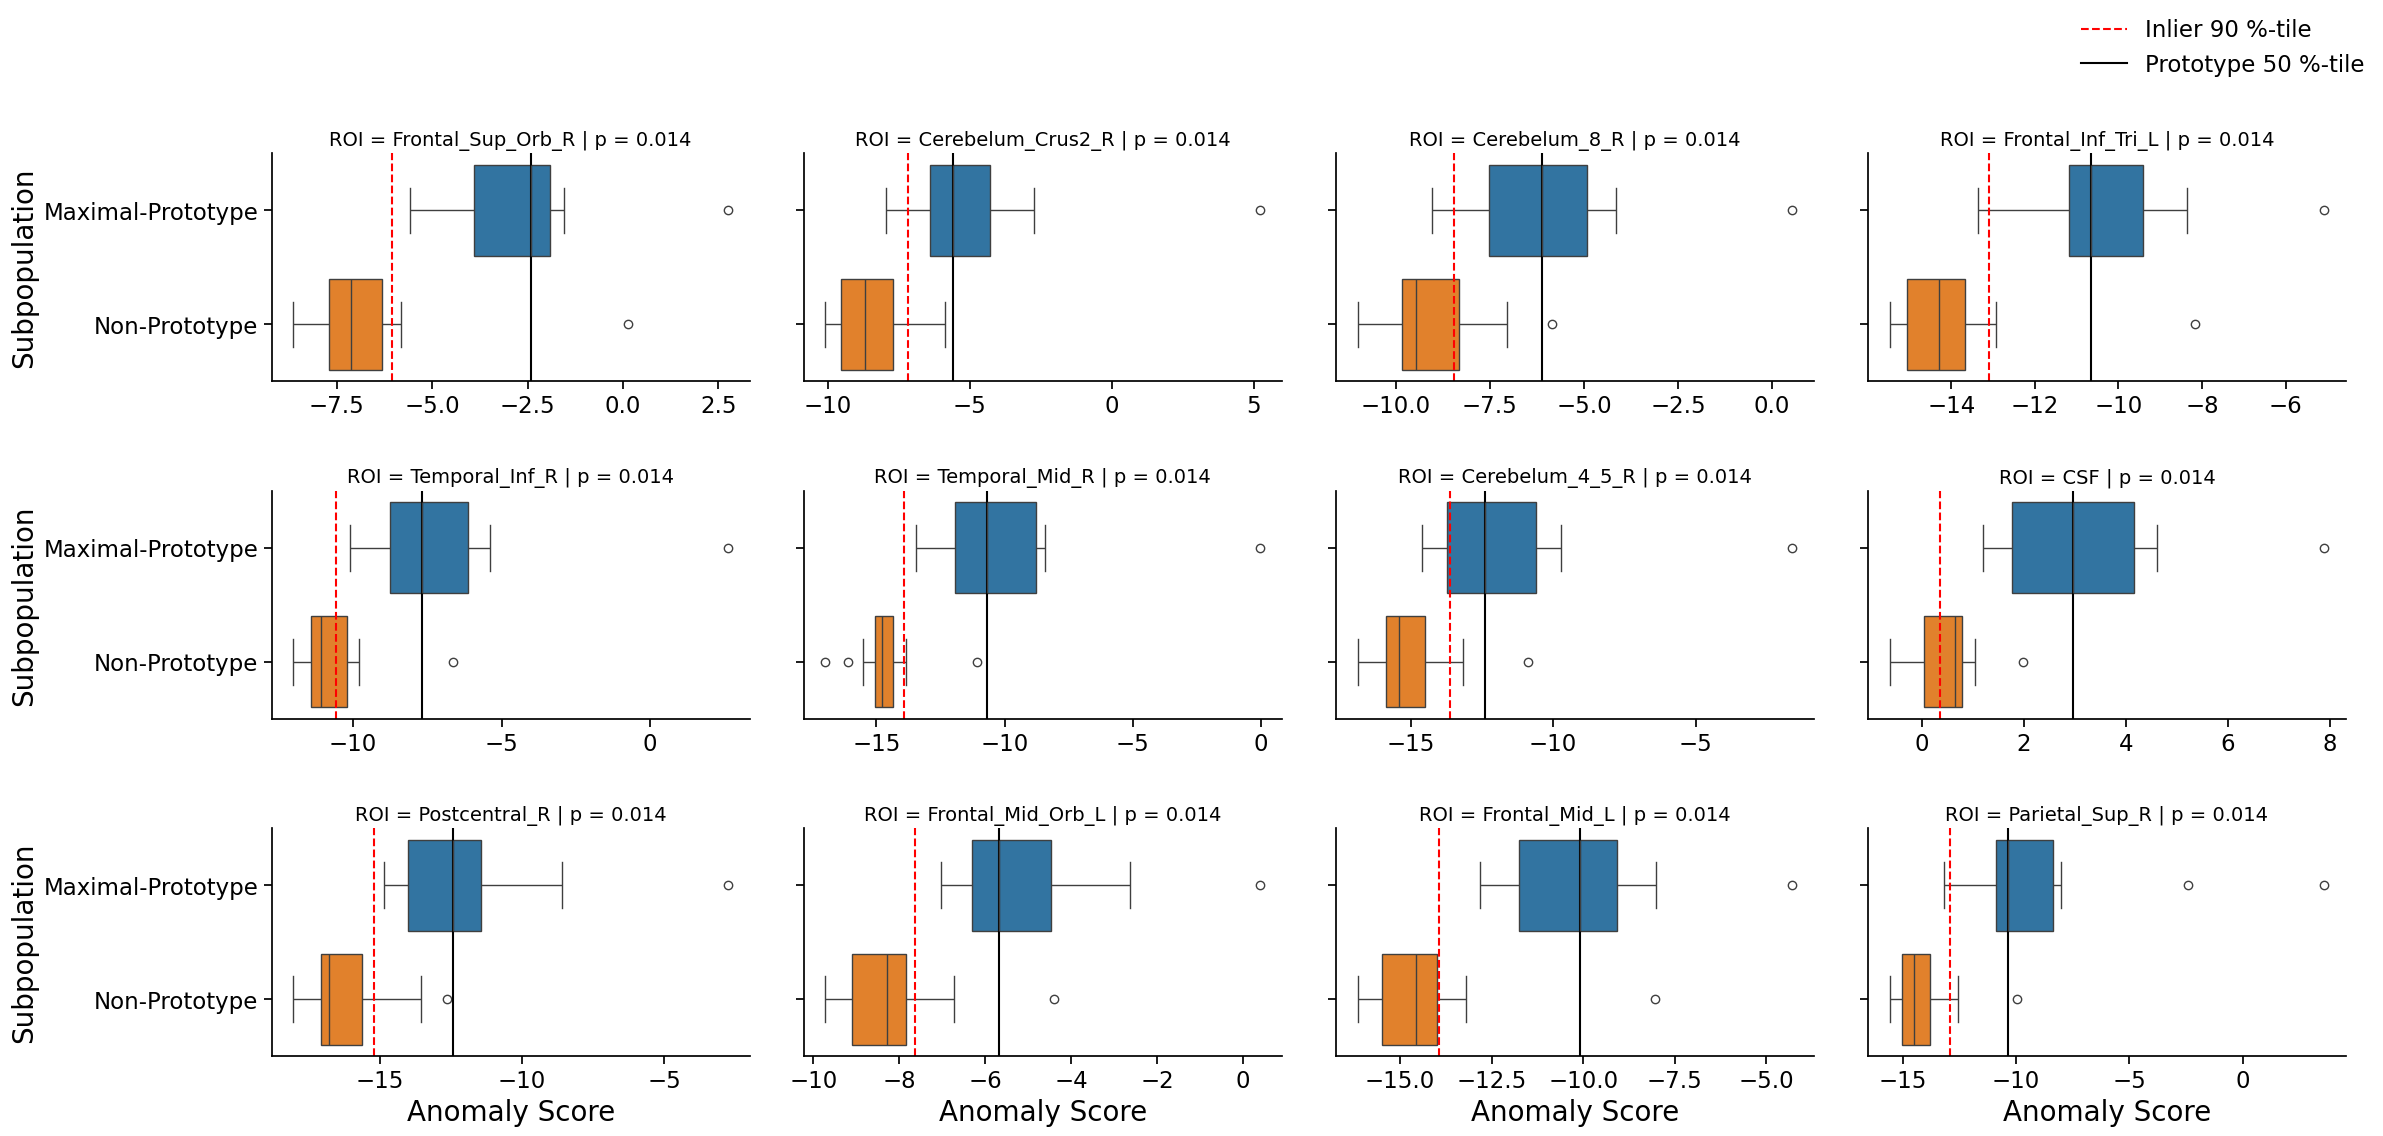

In [55]:
g = sns.FacetGrid(plotdf, col="ROI", col_wrap=4, col_order=roi_order[:12],
                  height=3.5, aspect=1.5, sharex=False, margin_titles=False)
g.map_dataframe(sns.boxplot, x="Anomaly Score", y='Subpopulation', hue='Subpopulation',
                palette='tab10', orient='h')
g.map_dataframe(add_refline)
g.add_legend(loc="upper right", bbox_to_anchor=(1, 1.1),)
# g.set_axis_labels(x_var= "Anomaly Score ->", y_var = "Subpopulation", clear_inner=True)
plt.tight_layout(h_pad=2)

# plt.savefig('figures/roi_boxplot.pdf', dpi=150,  bbox_inches='tight')

In [56]:
q = 0.99
refqs = roi_score_likelihoods.query("Cohort == 'IBIS-LR-Typical' ")[significant_prototype_rois["ROI"]].quantile(q)
protomedians = plotdf.query(f"Subpopulation == 'Maximal-Prototype'").groupby('ROI').median().loc[significant_prototype_rois["ROI"]]

higher_than_99 = [roi for roi in roi_order if protomedians.loc[roi].item() > refqs[roi].item()]
higher_than_99

/tmp/ipykernel_22175/3036443478.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  protomedians = plotdf.query(f"Subpopulation == 'Maximal-Prototype'").groupby('ROI').median().loc[significant_prototype_rois["ROI"]]


['Frontal_Sup_Orb_R',
 'Temporal_Inf_R',
 'Temporal_Mid_R',
 'CSF',
 'Postcentral_R',
 'Frontal_Mid_Orb_L',
 'Frontal_Mid_L',
 'Parietal_Sup_R',
 'Parietal_Sup_L',
 'Frontal_Inf_Tri_R',
 'Occipital_Sup_R',
 'Frontal_Sup_Medial_L',
 'Frontal_Sup_Orb_L',
 'Temporal_Pole_Mid_R',
 'Frontal_Sup_L',
 'Occipital_Mid_R',
 'Occipital_Sup_L',
 'Frontal_Sup_R',
 'Cerebelum_10_R',
 'Frontal_Inf_Orb_R',
 'Occipital_Inf_R',
 'Angular_R',
 'Frontal_Mid_R',
 'Frontal_Mid_Orb_R']

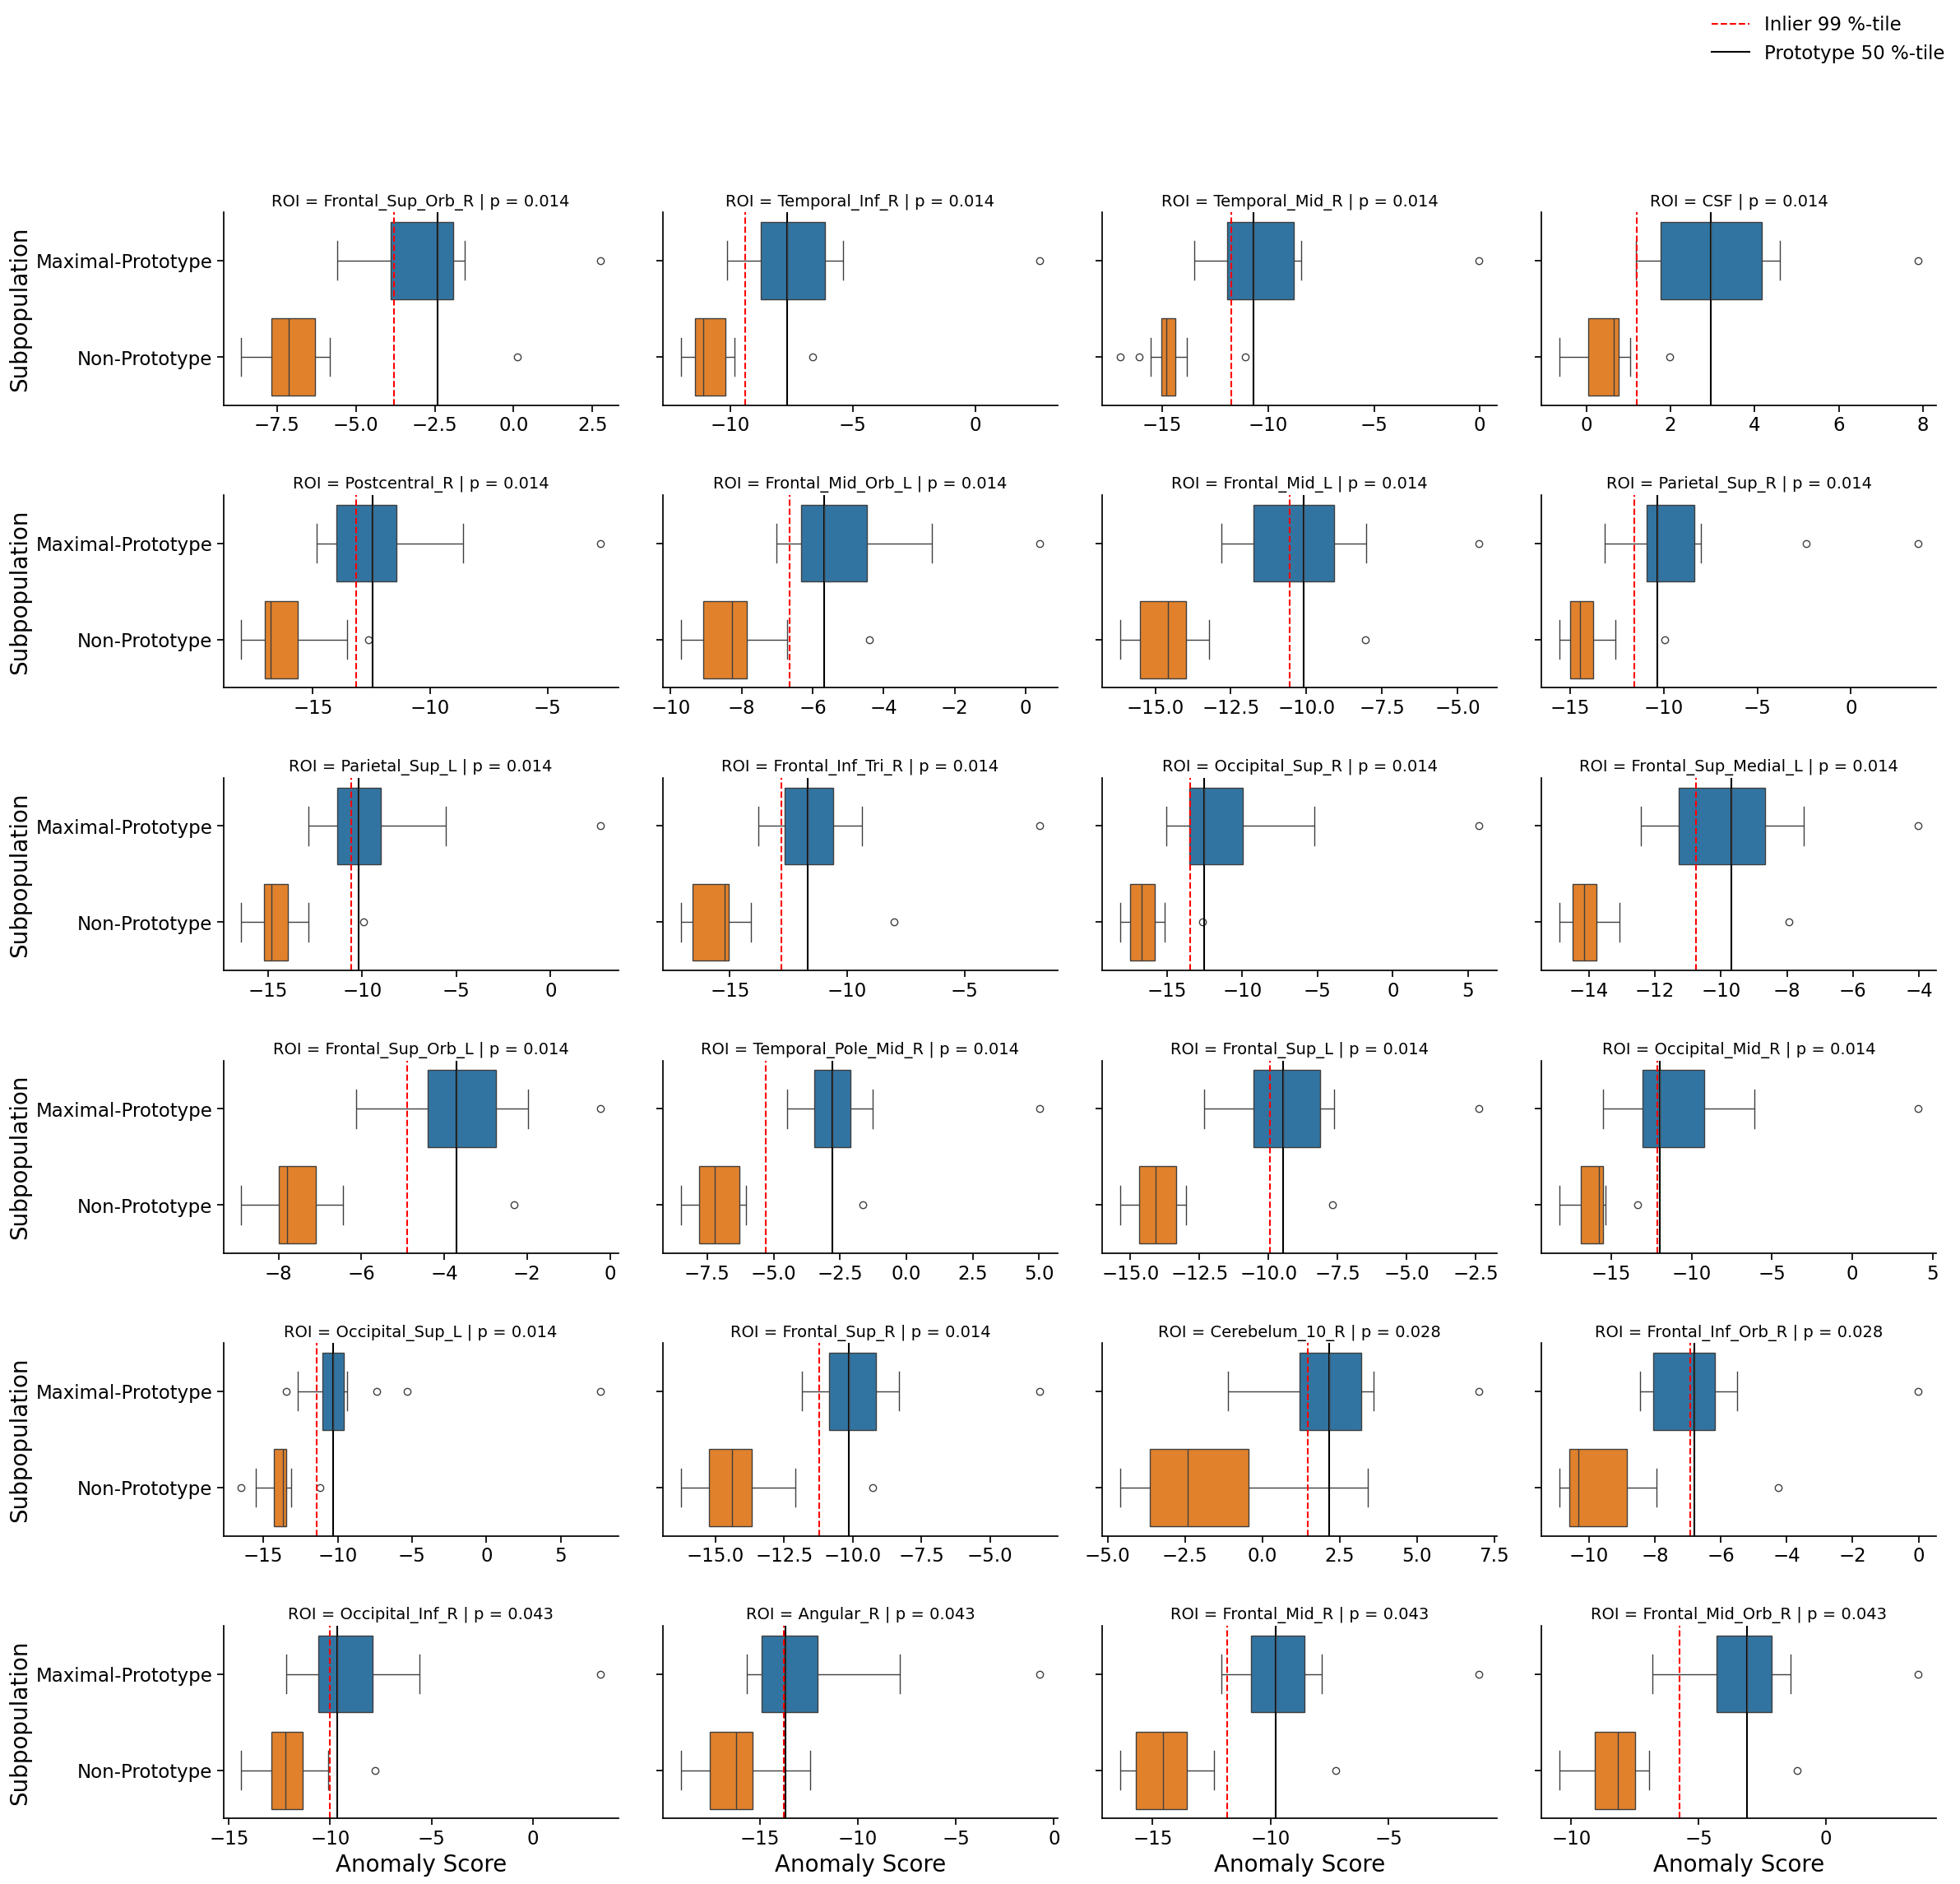

In [57]:
g = sns.FacetGrid(plotdf, col="ROI", col_wrap=4, col_order=higher_than_99,
                  height=3.5, aspect=1.5, sharex=False, margin_titles=False)
g.map_dataframe(sns.boxplot, x="Anomaly Score", y='Subpopulation', hue='Subpopulation',
                palette='tab10', orient='h')
g.map_dataframe(add_refline, q=0.99)
g.add_legend(loc="upper right", bbox_to_anchor=(1, 1.1),)
# g.set_axis_labels(x_var= "Anomaly Score ->", y_var = "Subpopulation", clear_inner=True)
plt.tight_layout(h_pad=2)

### Sample 11 has missing values and 15 is an outlier in `depressed_percentile`

In [58]:
ds_prototypes[behavior_cols]

CBCL-aggr_behav_score  CBCL-anx_prob_score  CBCL-anxious_score  \
0                    11.0                  4.0                 3.0   
1                     2.0                  1.0                 0.0   
2                    11.0                  4.0                 2.0   
3                     6.0                  0.0                 0.0   
4                     5.0                  1.0                 1.0   
5                     6.0                  2.0                 2.0   
6                     6.0                  3.0                 1.0   
7                     8.0                  0.0                 0.0   
8                     1.0                  1.0                 1.0   
9                    17.0                  6.0                 4.0   
10                    8.0                  3.0                 3.0   
11                   -1.0                 -1.0                -1.0   
12                    1.0                  0.0                 0.0   
13                    6.0                  0.0                 0.0   
14                    4.0                  1.0                 0.0   
15                    3.0                  1.0                 0.0   

    CBCL-attention_hyper_prob_score  CBCL-attention_prob_score  \
0                               5.0                        6.0   
1                               3.0                        4.0   
2                               6.0                        8.0   
3                               5.0                       10.0   
4                               5.0                        6.0   
5                              12.0                       13.0   
6                               6.0                        7.0   
7                               6.0                        7.0   
8                               1.0                        4.0   
9                               8.0                       12.0   
10                              6.0                       11.0   
11                             -1.0                       -1.0   
12                              2.0                        2.0   
13                              2.0                        3.0   
14                              6.0                        8.0   
15                              2.0                        4.0   

    CBCL-conduct_prob_score  CBCL-depressed_score  CBCL-depressive_prob_score  \
0                       2.0                   2.0                         3.0   
1                       0.0                   0.0                         1.0   
2                       3.0                   0.0                         3.0   
3                       2.0                   0.0                         1.0   
4                       1.0                   0.0                         0.0   
5                       1.0                   0.0                         3.0   
6                       4.0                   0.0                         0.0   
7                       5.0                   1.0                         1.0   
8                       1.0                   3.0                         1.0   
9                       8.0                   2.0                         2.0   
10                      2.0                   2.0                         1.0   
11                     -1.0                  -1.0                        -1.0   
12                      0.0                   0.0                         0.0   
13                      2.0                   1.0                         1.0   
14                      2.0                   2.0                         0.0   
15                      2.0                   5.0                         4.0   

    CBCL-externalizing_score  CBCL-internalizing_score  ...  \
0                       13.0                       5.0  ...   
1                        2.0                       1.0  ...   
2                       14.0                       4.0  ...   
3                        7.0                       2.0  ... 

In [59]:
# missing = ds_prototypes.loc[11].ID
# clean_ds_prototypes = ds_prototypes[~ds_prototypes['ID'].isin([missing])]
# len(clean_ds_prototypes)

In [60]:
# clean_ds_prototypes = ds_prototypes[ds_prototypes.ID != ds_prototypes.loc[9].ID]
# len(clean_ds_prototypes)

In [ ]:
np.random.seed(42)
non_numeric_cols = ['Cohort', 'ID', 'Identifiers', 'Sex']
corrmatrix, sigcorrdf, rel_rois = run_correlation_analysis(ds_prototypes.drop(columns=non_numeric_cols),
                                                           behavior_cols=behavior_cols,
                                                           correlation_thresh=0.0,
                                                           relevant_roi_columns=list(significant_prototype_rois['ROI']),
                                                           n_resamples=10_000)

/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/amahmood/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Running permutation test ... 
Correlation Threshold: 0.0
Feature Pairs: 1480 
Maximum DOF: 14 


1187it [3:10:47,  9.84s/it]

In [89]:
sigcorrdf['nsamples'].unique()

array([15, 12])

In [90]:
corrmatrix.loc[significant_prototype_rois['ROI'], behavior_cols].stack()

Frontal_Sup_Orb_R  CBCL-aggr_behav_score               -0.397940
                   CBCL-anx_prob_score                 -0.225969
                   CBCL-anxious_score                  -0.285380
                   CBCL-attention_hyper_prob_score     -0.636777
                   CBCL-attention_prob_score           -0.603112
                                                          ...   
Frontal_Mid_Orb_R  Vineland-inter_pers_rel_RAW_SCORE   -0.010309
                   Vineland-personal_RAW_SCORE         -0.248896
                   Vineland-play_leisure_RAW_SCORE     -0.103552
                   Vineland-receptive_RAW_SCORE         0.314626
                   Vineland-written_RAW_SCORE          -0.172185
Length: 1480, dtype: float64

In [91]:
corrmatrix.shape, sigcorrdf.shape

((89, 89), (1400, 6))

In [92]:
len(significant_prototype_rois['ROI']), len(behavior_cols)

(40, 49)

In [93]:
sigcorrdf

ROI                           Behavior      Corr  \
1231          Angular_L               CBCL-depressed_score  0.710932   
356     Occipital_Mid_L               CBCL-depressed_score  0.648977   
881      Temporal_Inf_R               CBCL-depressed_score  0.644330   
364     Occipital_Mid_L             CBCL-social_prob_score  0.638247   
3     Frontal_Sup_Orb_R    CBCL-attention_hyper_prob_score -0.636777   
...                 ...                                ...       ...   
202   Frontal_Sup_Orb_L     Vineland-copy_skills_RAW_SCORE  0.001473   
1115     Cerebelum_7b_R  Vineland-inter_pers_rel_RAW_SCORE  0.001473   
907      Temporal_Inf_R    Vineland-play_leisure_RAW_SCORE  0.000000   
1035     Cerebelum_10_R        VSA DAS_SA,PC_ABILITY_SCORE  0.000000   
834     Cerebelum_4_5_R      Vineland-expressive_RAW_SCORE  0.000000   

       p-value  nsamples  adjusted-p  
1231  0.000200        15    0.279972  
356   0.006999        15    0.419958  
881   0.000800        15    0.373296  
364   0.007799        15    0.419958  
3     0.023798        15    0.460228  
...        ...       ...         ...  
202   0.859714        15    0.990670  
1115  0.439156        15    0.898275  
907   0.600540        15    0.943791  
1035  0.518948        15    0.915022  
834   0.741126        15    0.986185  

[1400 rows x 6 columns]

<Axes: >

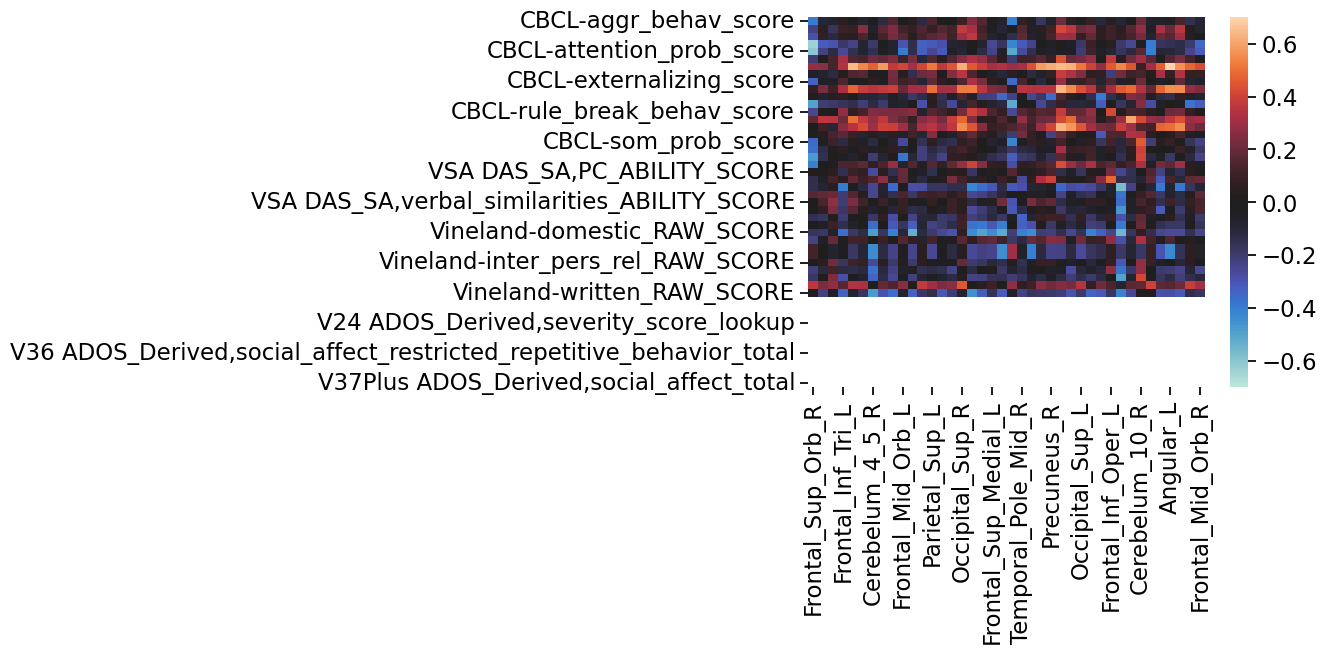

In [94]:
sns.heatmap(corrmatrix.loc[behavior_cols, roi_order], center=0, vmin=-0.7, vmax=0.7)

In [106]:
# sigcorrdf.to_csv("./corr_pvals.csv")
# corrmatrix.to_csv("./corrmatrix.csv")

In [96]:
# corrmatrix = pd.read_csv("./corrmatrix.csv", index_col=0)
# sigcorrdf = pd.read_csv("./corr_pvals.csv")
# sigcorrdf.head(3)

### Which Assessment shows high correlation with MSMA scores?

In [97]:
sigcorrdf['adjusted-p'] = false_discovery_control(sigcorrdf['p-value'], method='bh')
alpha = 0.01
print(f"Significant: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['p-value'] < alpha).sum()} / {len(sigcorrdf)}")
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.1
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")
alpha = 0.3
print(f"FDR: {alpha} -> Significant ROI-Behavior Correlations: {(sigcorrdf['adjusted-p'] < alpha).sum()} / {len(sigcorrdf)}")

Significant: 0.01 -> Significant ROI-Behavior Correlations: 32 / 1400
FDR: 0.01 -> Significant ROI-Behavior Correlations: 0 / 1400
FDR: 0.1 -> Significant ROI-Behavior Correlations: 0 / 1400
FDR: 0.3 -> Significant ROI-Behavior Correlations: 1 / 1400


In [98]:
(sigcorrdf['p-value'] < ONE_PERCENT).sum()

32

In [99]:
mask = sigcorrdf['p-value'] <= (ONE_PERCENT)
sigcorrdf[mask].groupby('Behavior').describe()

Corr                                          \
                               count      mean       std       min       25%   
Behavior                                                                       
CBCL-depressed_score            13.0  0.580231  0.078006  0.432135  0.518872   
CBCL-internalizing_score         5.0  0.525637  0.031760  0.490001  0.498910   
CBCL-sluggish_cogn_tempo_score   1.0  0.610468       NaN  0.610468  0.610468   
CBCL-social_prob_score           3.0  0.590580  0.043219  0.553951  0.566746   
VSA DAS_SA,rd_ABILITY_SCORE      7.0 -0.228730  0.166634 -0.572574 -0.253397   
Vineland-domestic_RAW_SCORE      3.0 -0.457229  0.060956 -0.525076 -0.482303   

                                                             p-value  \
                                     50%       75%       max   count   
Behavior                                                               
CBCL-depressed_score            0.590120  0.628842  0.710932    13.0   
CBCL-internalizing_score        0.524152  0.555334  0.559789     5.0   
CBCL-sluggish_cogn_tempo_score  0.610468  0.610468  0.610468     1.0   
CBCL-social_prob_score          0.579541  0.608894  0.638247     3.0   
VSA DAS_SA,rd_ABILITY_SCORE    -0.176407 -0.130810 -0.083718     7.0   
Vineland-domestic_RAW_SCORE    -0.439530 -0.423306 -0.407081     3.0   

                                          ... nsamples       adjusted-p  \
                                    mean  ...      75%   max      count   
Behavior                                  ...                             
CBCL-depressed_score            0.005153  ...     15.0  15.0       13.0   
CBCL-internalizing_score        0.007879  ...     15.0  15.0        5.0   
CBCL-sluggish_cogn_tempo_score  0.001200  ...     15.0  15.0        1.0   
CBCL-social_prob_score          0.007266  ...     15.0  15.0        3.0   
VSA DAS_SA,rd_ABILITY_SCORE     0.005828  ...     12.0  12.0        7.0   
Vineland-domestic_RAW_SCORE     0.005266  ...     15.0  15.0        3.0   

                                                                            \
                                    mean           std       min       25%   
Behavior                                                                     
CBCL-depressed_score            0.405600  3.988903e-02  0.279972  0.419958   
CBCL-internalizing_score        0.419958  6.206335e-17  0.419958  0.419958   
CBCL-sluggish_cogn_tempo_score  0.373296           NaN  0.373296  0.373296   
CBCL-social_prob_score          0.419958  0.000000e+00  0.419958  0.419958   
VSA DAS_SA,rd_ABILITY_SCORE     0.406626  2.276872e-02  0.373296  0.396627   
Vineland-domestic_RAW_SCORE     0.404404  2.694032e-02  0.373296  0.396627   

                                                              
                                     50%       75%       max  
Behavior                                                      
CBCL-depressed_score            0.419958  0.419958  0.419958  
CBCL-internalizing_score        0.419958  0.419958  0.419958  
CBCL-sluggish_cogn_tempo_score  0.373296  0.373296  0.373296  
CBCL-social_prob_score          0.419958  0.419958  0.419958  
VSA DAS_SA,rd_ABILITY_SCORE     0.419958  0.419958  0.419958  
Vineland-domestic_RAW_SCORE     0.419958  0.419958  0.419958  

[6 rows x 32 columns]

In [100]:
# # plt.Figure(dpi=100)
# g = sns.FacetGrid(sigcorrdf[mask], col_wrap=2, col="Behavior", height=4.5, aspect=2,
#                   sharex=False, sharey=False, despine=False)
# g.map(sns.barplot, "ROI", "Corr")

In [101]:
# dsdata = datadf.query("Cohort == 'IBIS-DS'")
# dsdata.loc[:, 'Prototypical'] = False
# dsdata.loc[dsdata['ID'].isin(ds_prototypes['ID']), 'Prototypical'] = True
# dsdata['Prototypical'].value_counts()

In [102]:
ref_max = reference_likelihoods.quantile(0.99)

In [103]:
sigcorrdf

ROI                           Behavior      Corr  \
1231          Angular_L               CBCL-depressed_score  0.710932   
356     Occipital_Mid_L               CBCL-depressed_score  0.648977   
881      Temporal_Inf_R               CBCL-depressed_score  0.644330   
364     Occipital_Mid_L             CBCL-social_prob_score  0.638247   
3     Frontal_Sup_Orb_R    CBCL-attention_hyper_prob_score -0.636777   
...                 ...                                ...       ...   
202   Frontal_Sup_Orb_L     Vineland-copy_skills_RAW_SCORE  0.001473   
1115     Cerebelum_7b_R  Vineland-inter_pers_rel_RAW_SCORE  0.001473   
907      Temporal_Inf_R    Vineland-play_leisure_RAW_SCORE  0.000000   
1035     Cerebelum_10_R        VSA DAS_SA,PC_ABILITY_SCORE  0.000000   
834     Cerebelum_4_5_R      Vineland-expressive_RAW_SCORE  0.000000   

       p-value  nsamples  adjusted-p  
1231  0.000200        15    0.279972  
356   0.006999        15    0.419958  
881   0.000800        15    0.373296  
364   0.007799        15    0.419958  
3     0.023798        15    0.460228  
...        ...       ...         ...  
202   0.859714        15    0.990670  
1115  0.439156        15    0.898275  
907   0.600540        15    0.943791  
1035  0.518948        15    0.915022  
834   0.741126        15    0.986185  

[1400 rows x 6 columns]

In [196]:
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 22, "axes.titlesize":22, 'axes.labelweight':'bold'})
fig, axs = plt.subplots(5,5, figsize=(36, 30),)
show_legend = True
for ax, row in zip(axs.flat, sigcorrdf[mask].sort_values(by='adjusted-p').iterrows()):
    ax.set_ymargin(0.01)
    idx, (roi, bhv, corr, p, n, ap) = row
    non_missing_samples = ds_proto_metadata[bhv] > -1
    sns.scatterplot(ds_proto_metadata[non_missing_samples], x=roi, y=bhv, style='Sex', hue='Met ASD CutOff',
                    palette='tab10',
                    ax=ax, legend=show_legend, s=200, alpha=1)
    sns.regplot(ds_proto_metadata[non_missing_samples], x=roi, y=bhv, scatter=False,
                color='black', ci=None, robust=True, truncate=True, ax=ax)
    ymin,ymax = ax.get_ylim()
    if ymin < 0:
        ax.set_ylim(0, None)
    ax.axvline(ref_max[roi], c='red',  linestyle='dashed', label='Inlier 99th %-tile')
#     ax.set_title(f"Correlation: {corr:.3f} - p<{p:.3f}")
#     ax.xaxis.label.set_fontsize(14)
#     ax.yaxis.label.set_fontsize(14)
    
    text_box = ax.text(0.65, 0.4, f"r = {corr:.3f}\np = {ap:.3f}", 
                       transform=ax.transAxes,
                       fontsize=20, color='white', 
                       bbox={'facecolor':'tab:blue', 'alpha':0.5,
                             'boxstyle':"round,pad=0.5"}
                      )
    
    if show_legend:
        show_legend = False
        fig.legend(loc='center right', fontsize='x-large', ncols=1)
        
    l = ax.legend()
    l.set_visible(False)

# plt.suptitle("Significant Correlations", fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(right=0.85)
plt.savefig('figures/regplot.pdf', dpi=150)
plt.close()

In [ ]:
# ds_prototypes[[roi, bhv]]

In [168]:
def plot_roi_regression(rows, axs, fig):
    show_legend = True
    for (ax1,ax2), row in zip(axs, rows):

        idx, (roi, bhv, corr, p, n, ap) = row
        non_missing_samples = ds_prototypes[bhv] > -1
        sns.scatterplot(ds_proto_metadata[non_missing_samples], x=roi, y=bhv, style='Met ASD CutOff', hue='Met ASD CutOff',
                        palette='tab10',
                        ax=ax1, legend=show_legend, s=200, alpha=1)
        ax1.axvline(ref_max[roi], c='red',  linestyle='dashed', label='Inlier 99th %-tile')
        sns.regplot(ds_prototypes[non_missing_samples], x=roi, y=bhv, scatter=False,
                    color='black', ci=None, robust=True, truncate=True, ax=ax1)
        ymin,ymax = ax1.get_ylim()
        if ymin < 0:
            ax1.set_ylim(0, None)
        ylab = ax1.get_ylabel().replace("_score", "")
        ylab = ylab.replace("_ABILITY_SCORE", "")
        ylab = ylab.replace("_RAW_SCORE", "")
        ax1.set_ylabel(ylab)

        rowdf = ds_proto_metadata[non_missing_samples].copy()
        rowdf[[roi, bhv]] = rowdf[[roi, bhv]].apply(rankdata)

        sns.scatterplot(rowdf, x=roi, y=bhv, style='Met ASD CutOff', hue='Met ASD CutOff', palette='tab10',
                        ax=ax2, legend=False, s=150, alpha=0.8)
        sns.regplot(rowdf, x=roi, y=bhv, scatter=False, color='black', ci=None,  ax=ax2,)
        ytext = 0.3 if corr < 0 else 0.7
        text_box = ax2.text(0.05, ytext, f"r = {corr:.3f}\np < {ap:.3f}", 
                           transform=ax2.transAxes,
                           fontsize=18, color='white', 
                           bbox={'facecolor':'tab:blue', 'alpha':0.5,
                                 'boxstyle':"round,pad=0.3"}
                          )
        ylab = ax2.get_ylabel().replace("ABILITY_SCORE", "rank").replace("RAW_SCORE", "rank")
        ylab = ylab.replace("score", "rank")
        
        ax2.set_ylabel(ylab)

        if show_legend:
            show_legend = False
            fig.legend(loc='upper right', fontsize='large', ncols=1,  title='Met ASD Cutoff')

        for ax in [ax1,ax2]:
            l = ax.legend()
            l.set_visible(False)

In [183]:
sns.set_context("notebook", font_scale=1.5, rc={"axes.labelsize": 20, "figure.titlesize":36, 'axes.labelweight':'bold'})
rows =  list(sigcorrdf[mask].sort_values(by='adjusted-p').iterrows())

nrows = 5
fig, axs = plt.subplots(nrows,2, figsize=(12, 4.5*nrows),)
figrows =  rows[:nrows]

plot_roi_regression(figrows, axs, fig)

# Add a label below the subplots
fig.suptitle(r"Higher is Anomalous ($\longrightarrow$)", y=0.03, fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.9, bottom=0.1)
plt.savefig('figures/rankcorrplot-fig1.pdf', dpi=150);
plt.close()

fig, axs = plt.subplots(len(rows)-nrows, 2, figsize=(12, 3.8 *(len(rows)-nrows)),)
# show_legend = True
figrows =  rows[nrows:]

plot_roi_regression(figrows, axs, fig)

# Add a label below the subplots
fig.suptitle(r"Higher is Anomalous ($\longrightarrow$)", y=0.03, fontsize=32)
plt.tight_layout(w_pad=2, h_pad=2)
plt.subplots_adjust(top=0.98, bottom=0.04)
plt.savefig('figures/rankcorrplot-fig2.pdf', dpi=150);
plt.close()
print('saved')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

saved


In [170]:
pmatrix = corrmatrix.copy()
corrected_pmatrix = corrmatrix.copy()

for row in sigcorrdf.iterrows():
    idx, (roi, bhv, corr, p, n, ap) = row
    pmatrix.loc[roi, bhv] = p
    pmatrix.loc[bhv, roi] = p
    
    corrected_pmatrix.loc[roi, bhv] = ap
    corrected_pmatrix.loc[bhv, roi] = ap

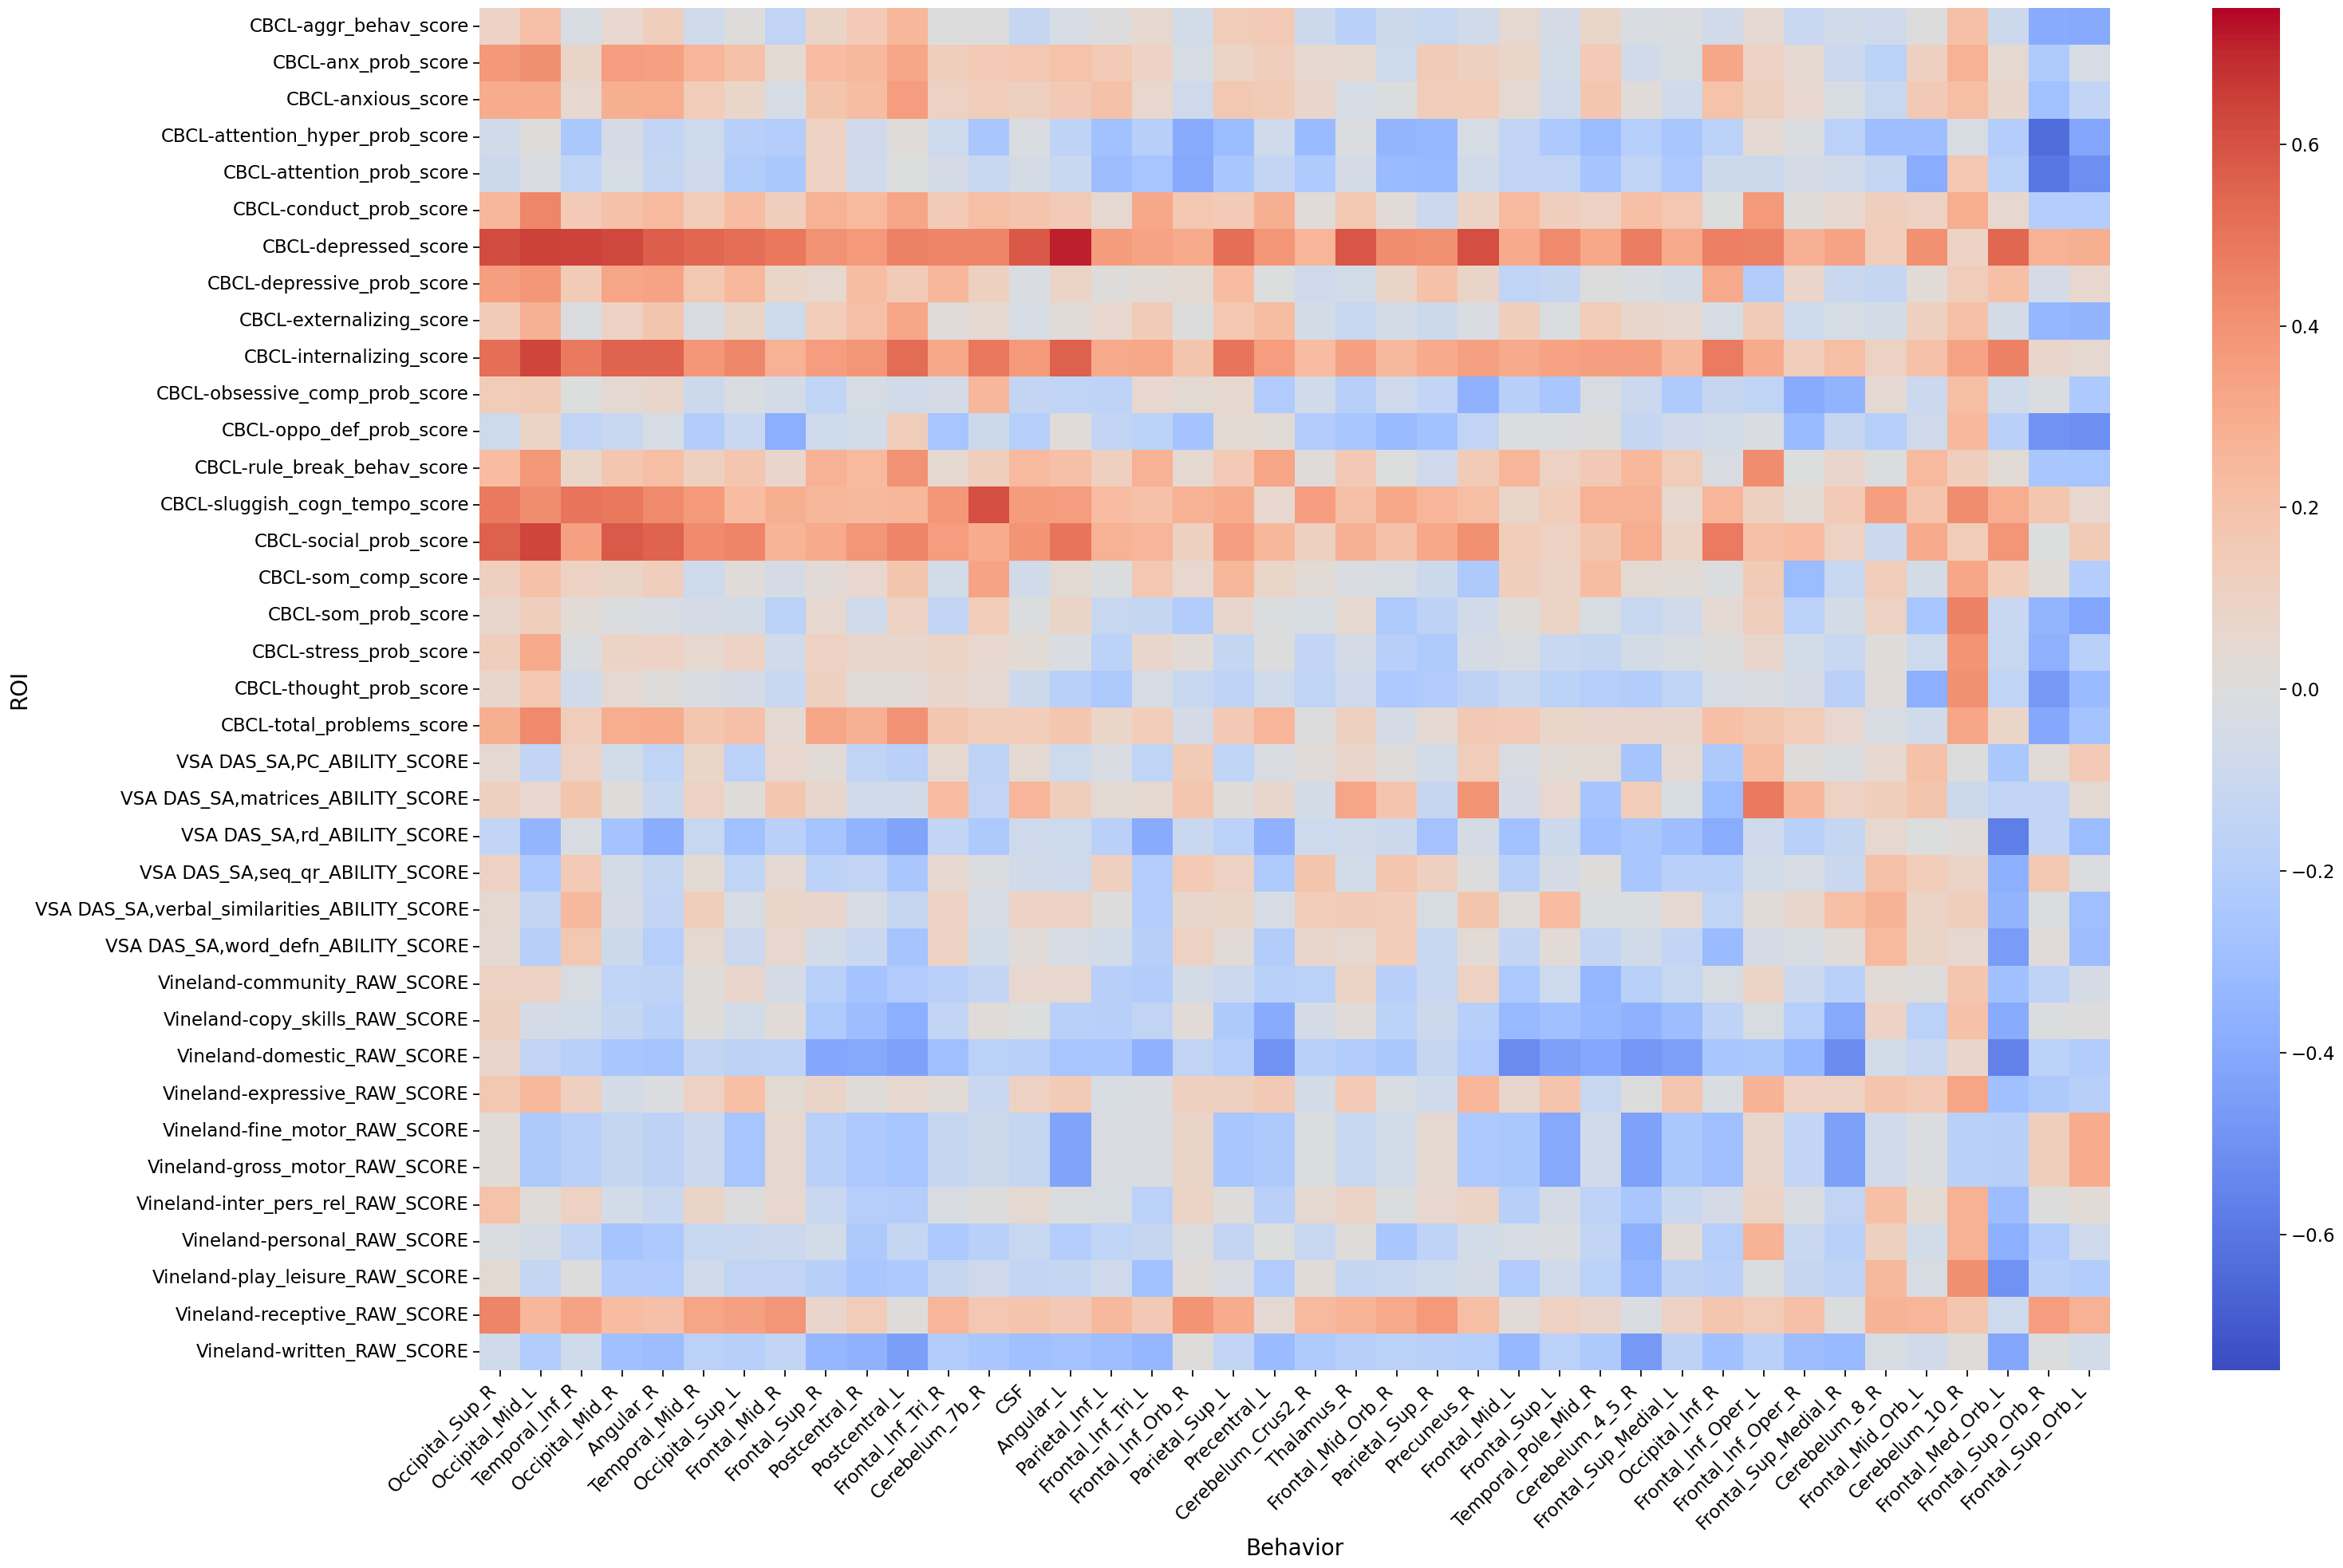

In [171]:
fig, axs = plt.subplots(1,1, figsize=(32,20))
# corrs = corrmatrix.loc[sigcorrdf['ROI'].unique(), sigcorrdf['Behavior'].unique()]
relevant_behaviors = corrmatrix.loc[behavior_cols].mean(1).dropna().index
relevant_rois = corrmatrix.loc[list(significant_prototype_rois['ROI'])].mean(1).sort_values(ascending=False).index

sns.heatmap(corrmatrix.loc[relevant_behaviors, relevant_rois], cmap='coolwarm', vmin=-0.75, vmax=0.75, ax=axs, annot=False)
# axs.set_title(f"Correlation Matrix")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig('figures/full_corrmatrix.pdf', dpi=150)

### p-value Matrix

In [172]:
fig, axs = plt.subplots(1,1, figsize=(32,20))
pmax = thresh = 0.1
pmin = 0.0001
log_norm = LogNorm(vmin=pmin, vmax=pmax)
significant_ps = pmatrix.loc[relevant_behaviors, relevant_rois] < thresh

sns.heatmap(pmatrix.loc[relevant_behaviors, relevant_rois]*significant_ps, ax=axs, annot=False,
            fmt=".3f",
            norm=log_norm,
            mask=~significant_ps,
#             vmin=0.001, vmax=0.1,
            cmap='rocket', 
            cbar_kws={'ticks': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1], 'extend':'max'}
           )
# sns.heatmap(pmatrix[significant_ps].loc[relevant_behaviors, relevant_rois], ax=axs, annot=False)
axs.set_facecolor("seashell")
# axs.set_title(f"Raw p-values below {thresh}")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig('figures/pmatrix.pdf', dpi=150)
plt.close()

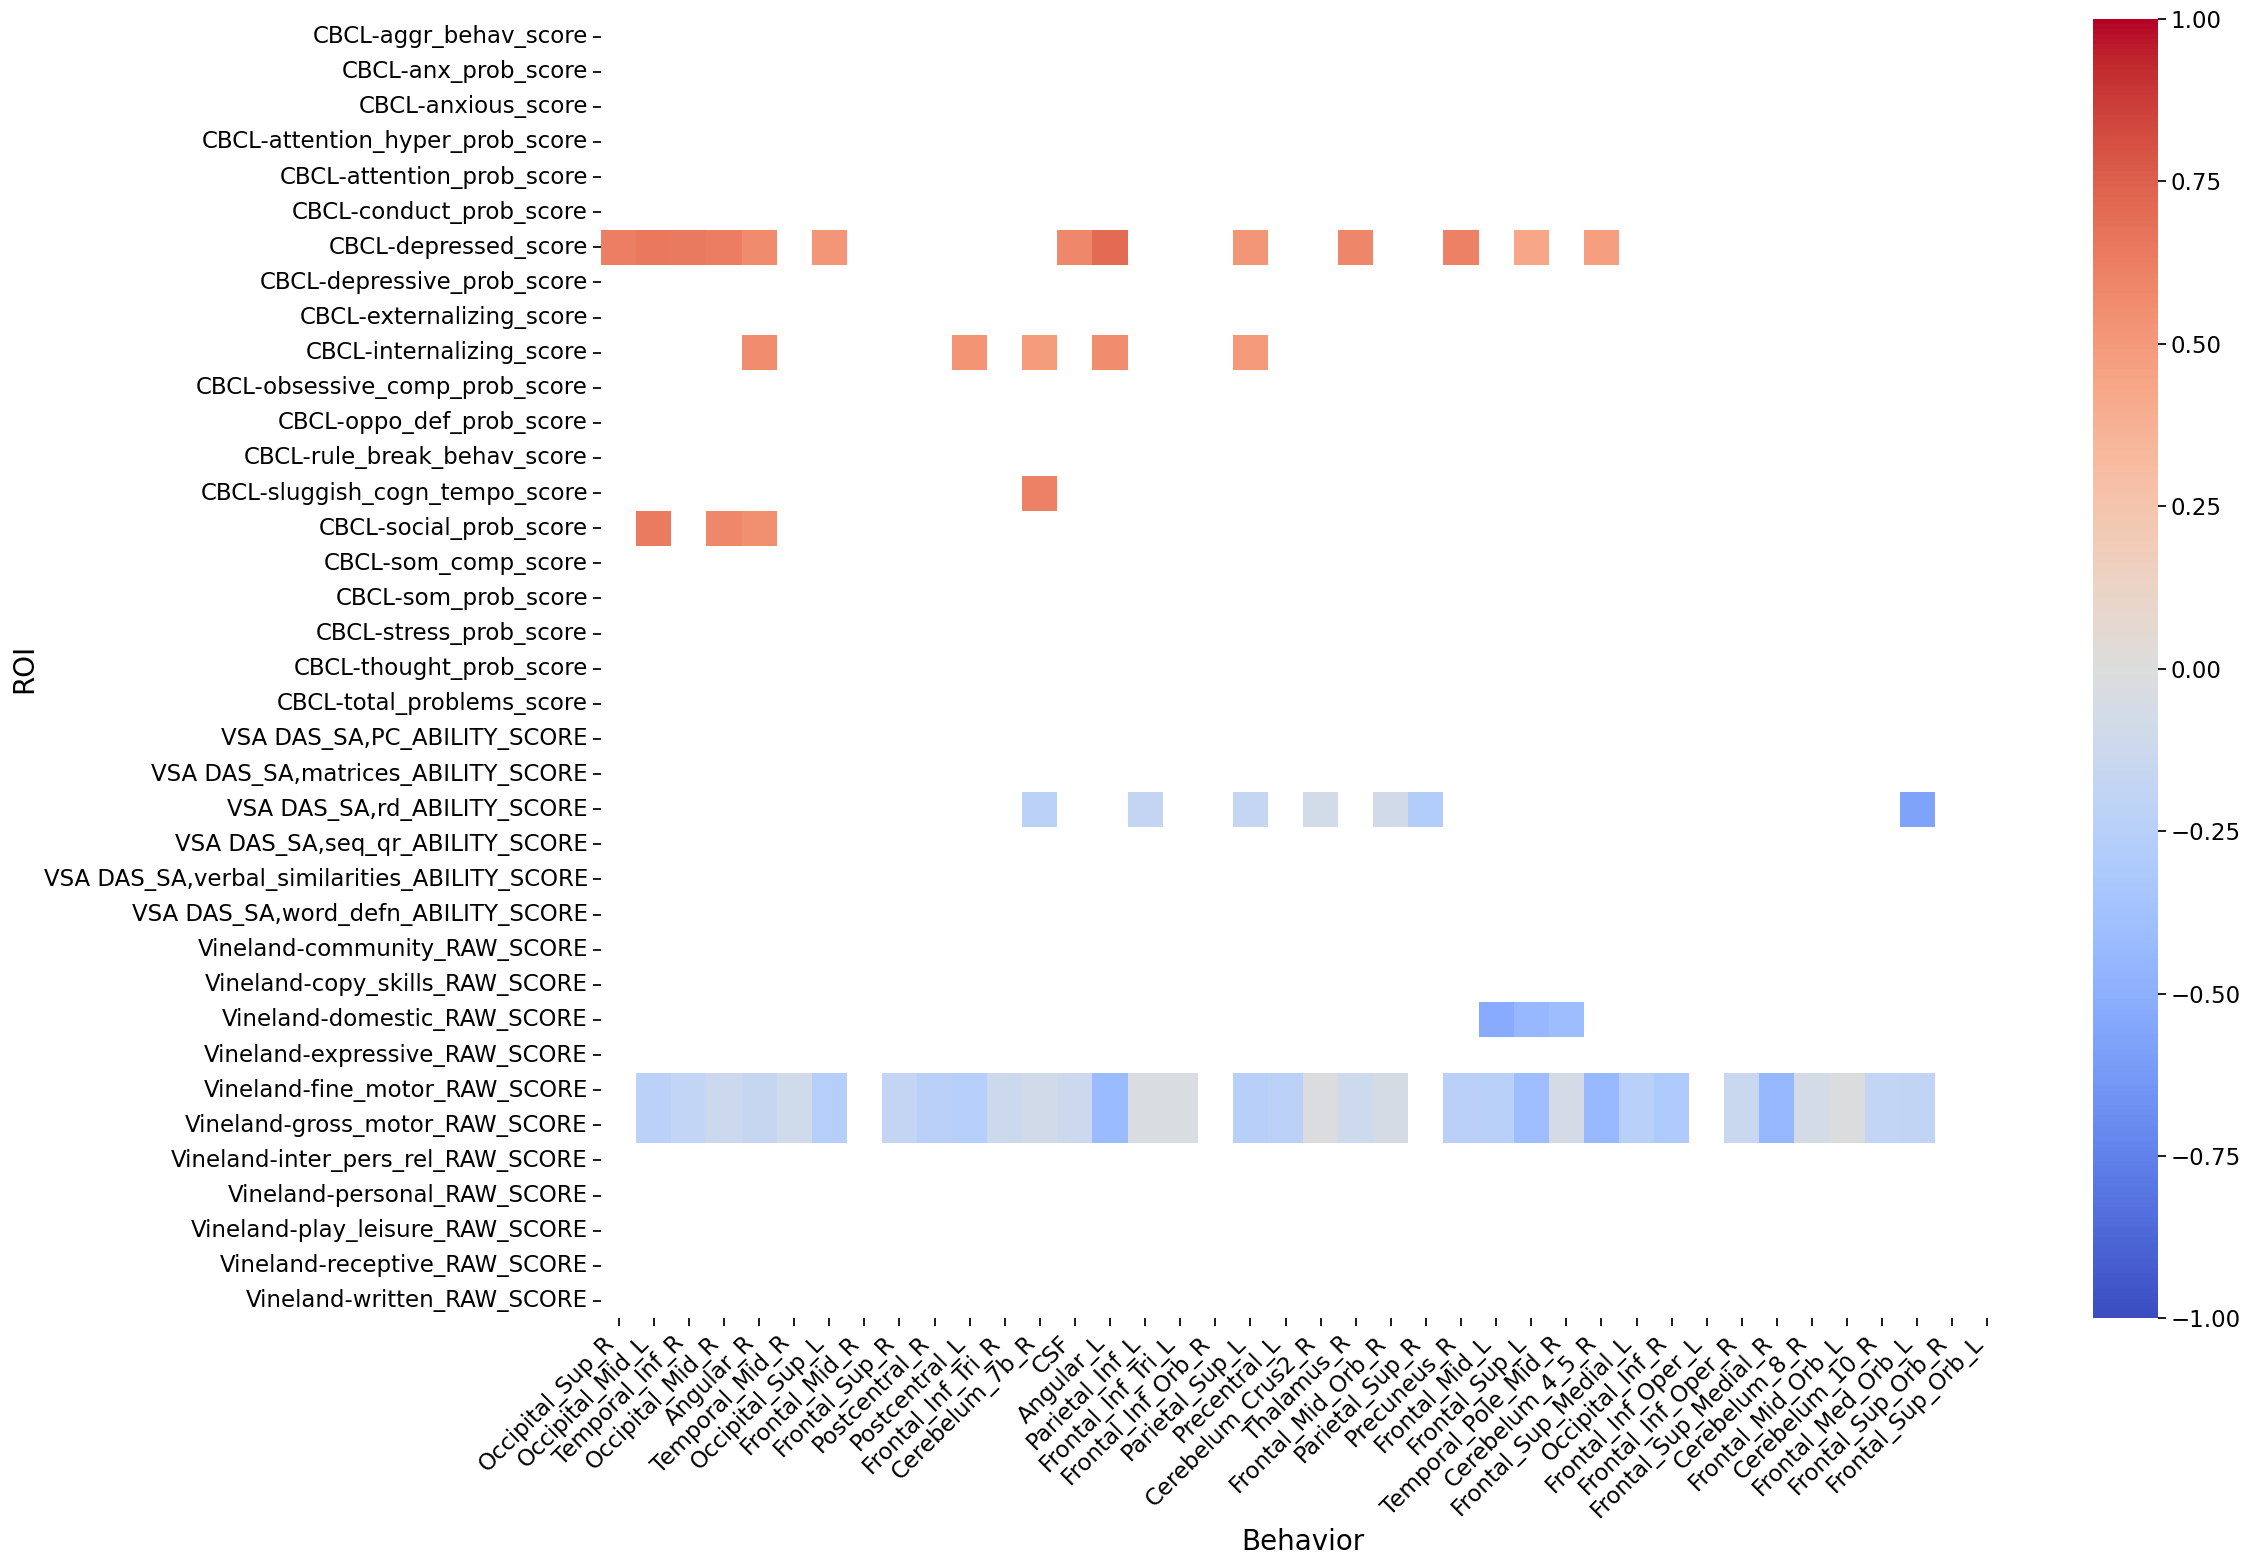

In [173]:
fig, axs = plt.subplots(1,1, figsize=(24,16))

pmask = pmatrix.loc[relevant_behaviors, relevant_rois] > 0.01
sns.heatmap(corrmatrix.loc[relevant_behaviors, relevant_rois], cmap='coolwarm', vmin=-1, vmax=1, ax=axs, mask=pmask)
# axs.set_title(f"Correlation Matrix")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
# plt.savefig('figures/full_corrmatrix.pdf', dpi=150)

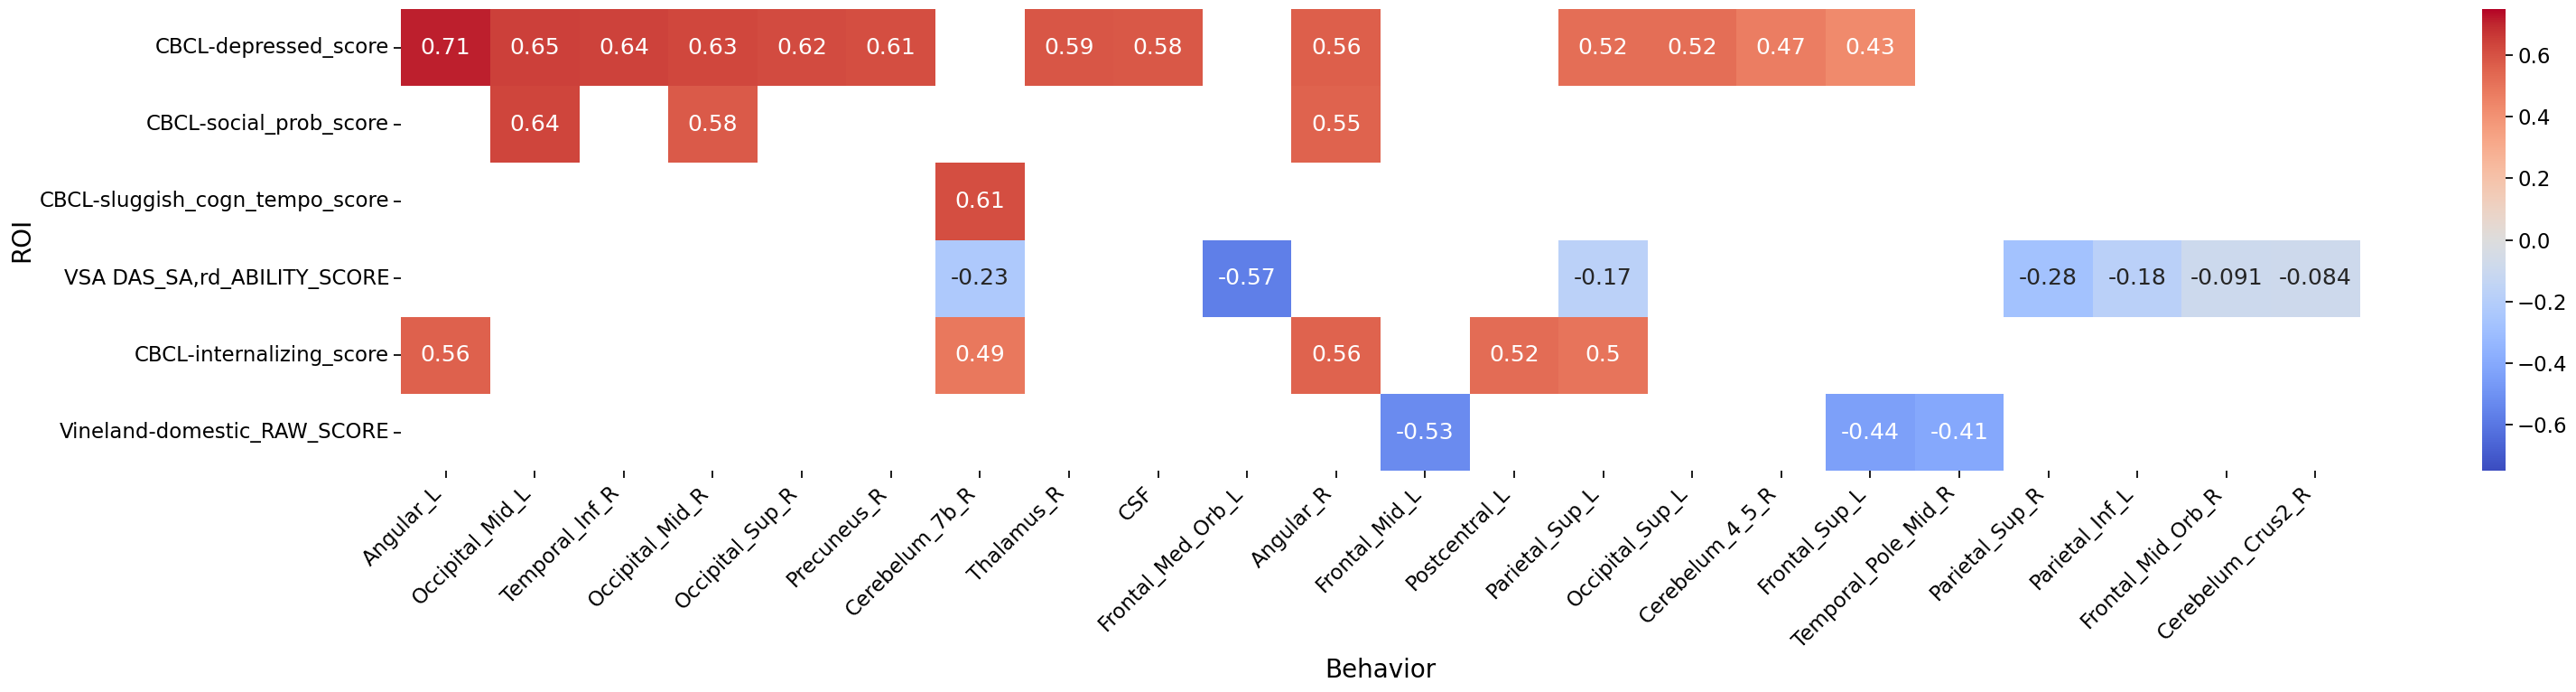

In [174]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
thresh = 0.01
significant_correlation = pmatrix < thresh

relcorrs = sigcorrdf[sigcorrdf['p-value'] < thresh]
# corrs = corrmatrix[significant_correlation].loc[sigcorrdf['ROI'].unique(), sigcorrdf['Behavior'].unique()]
# relevant_behaviors = corrs.count(axis=0)[corrs.count(axis=0) > 1].sort_values(ascending=False).index
# relevant_rois = corrs.count(axis=1)[corrs.count(axis=1) > 1].sort_values(ascending=False).index
relevant_behaviors, relevant_rois = relcorrs['Behavior'].unique(), relcorrs['ROI'].unique()

sns.heatmap(corrmatrix[significant_correlation].loc[relevant_behaviors, relevant_rois],
            cmap='coolwarm', vmin=-0.75, vmax=0.75, ax=axs, annot=True)
# axs.set_title(f"Raw p-values below {thresh}")
plt.xticks(rotation=45, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig('figures/sig_roi_corrs.pdf', dpi=150)

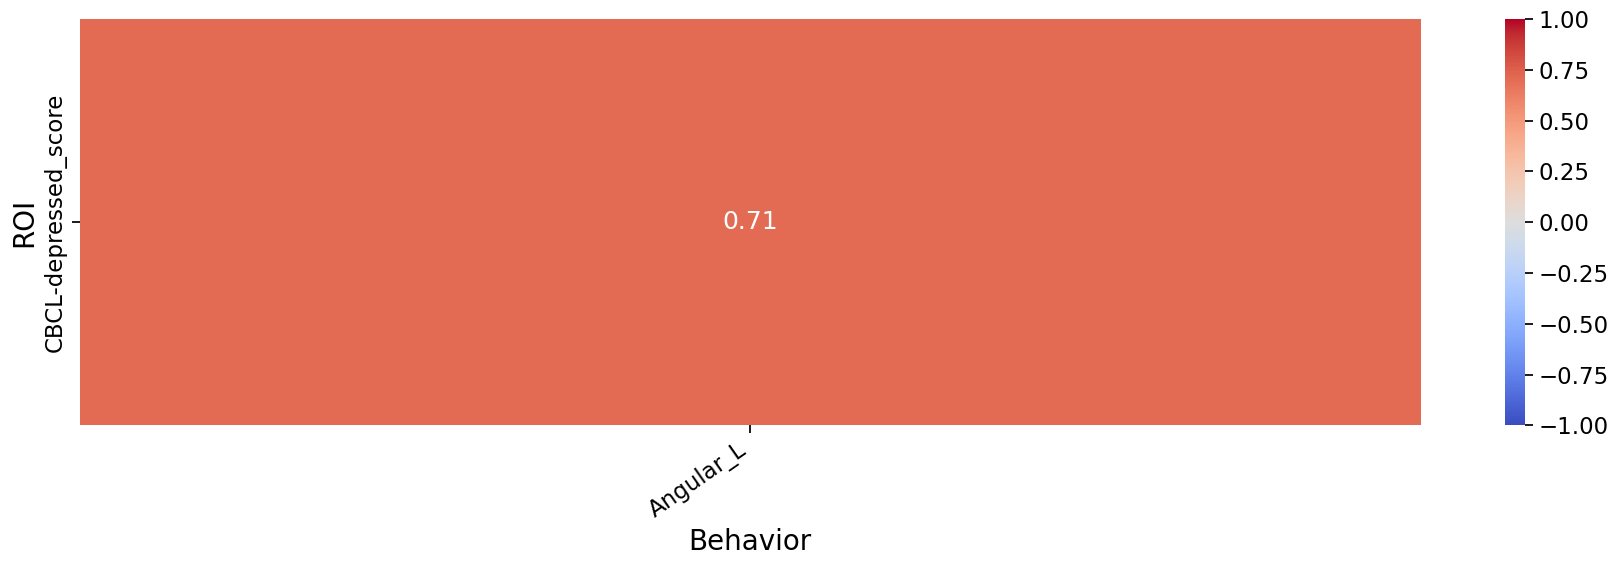

In [166]:
fig, axs = plt.subplots(1,1, figsize=(18,6))
# sns.heatmap(corrmatrix, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0])
# axs[0].set_xticks([])
thresh = TEN_PERCENT * 3
relcorrs = sigcorrdf[sigcorrdf['adjusted-p'] < thresh]
# corrs = corrmatrix[corrected_pmatrix < TEN_PERCENT].loc[relcorrs['ROI'].unique(), relcorrs['Behavior'].unique()]
# relevant_behaviors = corrs.count(axis=0)[corrs.count(axis=0) > 0].sort_values(ascending=False).index
# relevant_rois = corrs.count(axis=1)[corrs.count(axis=1) > 0].sort_values(ascending=False).index
relevant_behaviors, relevant_rois = relcorrs['Behavior'].unique(), relcorrs['ROI'].unique()

sns.heatmap(corrmatrix[corrected_pmatrix < thresh].loc[relevant_behaviors, relevant_rois],
            annot=True,
            cmap='coolwarm', vmin=-1, vmax=1, ax=axs,)
# axs.set_title(f"Significant Correlations (corrected-p < {TEN_PERCENT})", pad=20)
plt.xticks(rotation=35, ha='right');
plt.xlabel("Behavior")
plt.ylabel("ROI")
plt.tight_layout()
# plt.savefig('figures/corrected_sig_roi_corrs.pdf', dpi=150)

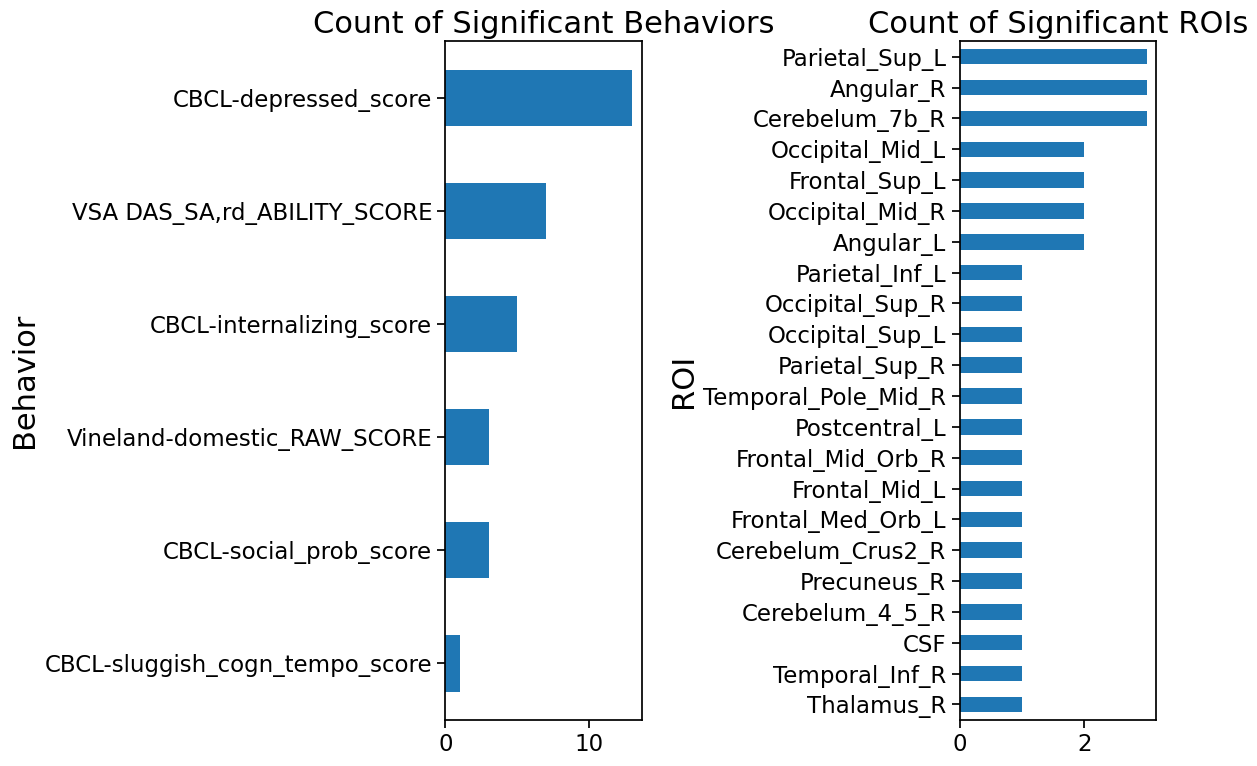

In [185]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
relcorrs.groupby('Behavior')['ROI'].count().sort_values(ascending=True).plot(kind='barh', ax=axs[0])
axs[0].set_title(f"Count of Significant Behaviors")
# plt.xticks(rotation=45, ha='right');

relcorrs.groupby('ROI')['Behavior'].count().sort_values(ascending=True).plot(kind='barh', ax=axs[1])
axs[1].set_title(f"Count of Significant ROIs")
# axs[1].set_xticks(rotation=45, ha='right');
plt.tight_layout()
# plt.title("Number Behavior/ROIs in a Significant Pair")